In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
import math
from copy import deepcopy
import itertools
from operator import itemgetter
from collections import defaultdict, Counter
import unittest

In [2]:
# dodac produkcje zwracaja nowe pod grafy <check> 
# dodac do node'ow typu I id parenta, pierwszy node Typu I bedzie zawierac parenta -1 <check>
# layer ma byc lista <check>
# wizualizacja warstwy (brutem) <check>
# dodac check czy mozna wywolac <check>
#czyscic kernel i out przed pushem

In [3]:
class Id_creator:
    def __init__(self):
        self.last_id = -1
    def get_id(self):
        self.last_id +=1
        return self.last_id
    def __call__(self):
        return self.get_id()
    
    
class CannotExecuteProduction(Exception):
        pass
    
    
class Graph_layers:
    def __init__(self):
        self._node_id_gen =  Id_creator()
        G = nx.Graph()
        G.add_nodes_from([(self._node_id_gen(), {'pos': (0,0),'type': 'e'})])
        self._layers=[[G]]
        
    def get_layer(self, i):
        return self._layers[i]
    
    def add_to_layer(self,i,G):
        return self._layers[i].append(G)
    
    def add_to_last_layer(self,G):
        return self._layers[-1].append(G)
        
    def add_new_layer(self, G_new):
        self._layers.append([G_new])            
        
    def get_last_layer_index(self):
        return len(self._layers) - 1
    
    def get_last_layer(self,i):
        return self._layers[i]
    
    def display_i_layer(self, i):
        G_layer = self._layers[i]
        G = self._layers[i][0] if  len(self._layers[i])==1 else reduce(nx.algorithms.operators.binary.compose,G_layer)
        
        pos = nx.get_node_attributes(G, 'pos')
        nx.draw_networkx(G, pos)
        plt.show()
        
    def display_layer(self, layer):
        G_layer = layer
        G = layer[0] if  len(layer)==1 else reduce(nx.algorithms.operators.binary.compose,G_layer)
        
        pos = nx.get_node_attributes(G, 'pos')
        nx.draw_networkx(G, pos)
        
    def get_node_id_gen(self):
        return self._node_id_gen

In [4]:
def get_graph_i_nodes(G):
    return [key for (key, value) in nx.get_node_attributes(G, 'type').items() if value == 'I']

def get_graph_e_nodes(G):
    return [key for (key, value) in nx.get_node_attributes(G, 'type').items() if value == 'e']

def get_graph_i_nodes_by_ids(G, ids):
    return [key for (key, value) in nx.get_node_attributes(G, 'type').items() if value == 'I' and key in ids]

def get_parent_of_nodes(G, nodes):
    return list(set([value for (key, value) in nx.get_node_attributes(G, 'parent').items() if key in nodes]))

def get_distance(fst, snd):
    return math.sqrt((fst[0]-snd[0])**2 + (fst[1]-snd[1])**2)

In [5]:
class node_grouping(defaultdict):
    def __init__(self):
        super(node_grouping, self).__init__(list)

    def select(self, *keys):
        return tuple(self[key] for key in keys)

def group_nodes_by_attr(graph, n_ids, attr, transform=None):
    grouping = node_grouping()
    for n_id in n_ids:
        node = graph.nodes[n_id]
        if attr not in node:
            continue
        key = node[attr]
        if transform:
            key = transform(key)
        grouping[key].append(n_id)
    return grouping

def find_common_e_neighbors(graph, id1, *ids):
    intersection = { n_id for n_id in graph.neighbors(id1) if graph.nodes[n_id]['type'].lower() == 'e' }
    for xid in ids:
        intersection.intersection_update({ n_id for n_id in graph.neighbors(xid) if graph.nodes[n_id]['type'].lower() == 'e' })
    return intersection

def find_common_group_e_neighbors(graph, group1, *groups):
    intersection = { neighbor for n_id in group1 for neighbor in graph.neighbors(n_id) if graph.nodes[neighbor]['type'].lower() == 'e' }
    for group in groups:
        intersection.intersection_update({ neighbor for n_id in group for neighbor in graph.neighbors(n_id) if graph.nodes[neighbor]['type'].lower() == 'e' })
        intersection.difference_update(set(group))
    return intersection - set(group1)

def isapprox(a, b):
    eps = 1e-10
    ax, ay = a
    bx, by = b
    return abs(ax - bx) <= eps and abs(ay - by) <= eps

In [6]:
def p1(G, base_node_id, n_id_gen, side_len=2, max_random_offset = 0):
    assert(G.nodes[base_node_id]['type'].lower() == 'e' )
    assert(len(G.nodes)==1)
    all_new_nodes = []
    all_new_edges = []
    base_pos = G.nodes[base_node_id]['pos']
    x_offset = ((np.random.random()-0.5) * max_random_offset * 2)
    y_offset = ((np.random.random()-0.5) * max_random_offset * 2)
    i_node_x, i_node_y = base_pos[0], base_pos[1]
    i_node = (n_id_gen(), {'pos': (i_node_x+x_offset, i_node_y-y_offset), 'type': 'I','parent': base_node_id})
    all_new_nodes.append(i_node)
    
    half_side_len = side_len/2
    e_nodes = [
        (n_id_gen(), {'pos': (i_node_x - half_side_len, i_node_y + half_side_len),'type': 'e'}),
        (n_id_gen(), {'pos': (i_node_x + half_side_len, i_node_y + half_side_len),'type': 'e'}),
        (n_id_gen(), {'pos': (i_node_x + half_side_len, i_node_y - half_side_len),'type': 'e'}),
        (n_id_gen(), {'pos': (i_node_x - half_side_len, i_node_y - half_side_len),'type': 'e'})
    ]
    for i in range(len(e_nodes)):
        all_new_edges.extend([(e_nodes[i][0],e_nodes[i+1 if i + 1 < len(e_nodes) else 0][0])])
        all_new_edges.extend([(i_node[0],e_nodes[i][0])])
    
    all_new_nodes.extend(e_nodes)
    nG = nx.Graph()
    nG.add_nodes_from(all_new_nodes)
    nG.add_edges_from(all_new_edges)
    return nG, i_node


In [7]:
def conc_duplicates(G):
    org_nodes = list(G.nodes(data=True))

    org_nodes_dict = {}
    for node_id,data in org_nodes:
        try:
            org_nodes_dict[data['pos']].append(node_id)
        except KeyError:
            org_nodes_dict[data['pos']]=[node_id]

    nodes_to_replace = {} #keys nodes to be deleted, values nodes to replace them
    for key,ids in org_nodes_dict.items():
        if len(ids) > 1:
            for id_ in ids[1:]:
                nodes_to_replace[id_] = ids[0]
                
    for old_node, new_node in nodes_to_replace.items():
        neighbors = list(G.neighbors(old_node))
        for n in neighbors:
            G.remove_edge(old_node,n)
            G.add_edge(new_node,n)
        G.remove_node(old_node)
    return G

In [8]:
def avg_pos(pos1, pos2):
    return ((pos1[0] + pos2[0])/2, (pos1[1] + pos2[1])/2)

def rm_edge_if_exists(G,n1id,n2id):
    try:
        G.remove_edge(n1id,n2id)
    except nx.NetworkXError:
        pass
    


#     e0 - - - e1
#      | \    / |
#      |  I0    |
#      | /   \  |
#     e2 - - - e3
#
#          |
#         \/
#
#     e0 - - - n0 - - - e1
#     | \    / | \    / |
#     |  I1    |  I2    |
#     | /   \  | /   \  |
#    n1 - - - n2 - - - n3
#     | \    / | \    / |
#     |  I3    |  I4    |
#     | /   \  | /   \  |
#    e2 - - - n4 - - - e3

def p2(G, base_node_id, n_id_gen):
    assert(G.nodes[base_node_id]['type'].lower() == 'i')
    nG = nx.Graph()
    es = list(G.neighbors(base_node_id))
    if len(es) != 4:
        raise CannotExecuteProduction
    e0, e1, e2, e3 = None, None, None, None
    baseX, baseY = G.nodes[base_node_id]['pos']
    for ex in es:
        x,y = G.nodes[ex]['pos']
        if x<baseX:
            if y<baseY:
                e2= (ex,G.nodes[ex])
            if y>baseY:
                e0= (ex,G.nodes[ex])
        else:
            if y<baseY:
                e3= (ex,G.nodes[ex])
            if y>baseY:
                e1= (ex,G.nodes[ex])
    if not(G.has_edge(e0[0],e1[0]) and\
            G.has_edge(e1[0],e3[0]) and\
            G.has_edge(e3[0],e2[0]) and\
            G.has_edge(e0[0],e2[0]) and\
            G.has_edge(e0[0],base_node_id) and\
            G.has_edge(e1[0],base_node_id) and\
            G.has_edge(e2[0],base_node_id) and\
            G.has_edge(e3[0],base_node_id)\
            ):
        raise CannotExecuteProduction
    #prepare all new verticies accord to map above
    e0 = (n_id_gen(),{'pos': e0[1]['pos'],'type' : e0[1]['type']})
    e1 = (n_id_gen(),{'pos': e1[1]['pos'],'type' : e1[1]['type']})
    e2 = (n_id_gen(),{'pos': e2[1]['pos'],'type' : e2[1]['type']})
    e3 = (n_id_gen(),{'pos': e3[1]['pos'],'type' : e3[1]['type']})

    n0 = (n_id_gen(),{'pos' : avg_pos(e0[1]['pos'],e1[1]['pos']),'type':'e'})
    n1 = (n_id_gen(),{'pos' : avg_pos(e0[1]['pos'],e2[1]['pos']),'type':'e'})
    n2 = (n_id_gen(),{'pos' : avg_pos(e1[1]['pos'],e2[1]['pos']),'type':'e'})
    n3 = (n_id_gen(),{'pos' : avg_pos(e1[1]['pos'],e3[1]['pos']),'type':'e'})
    n4 = (n_id_gen(),{'pos' : avg_pos(e2[1]['pos'],e3[1]['pos']),'type':'e'})
    
    I1 = (n_id_gen(),{'pos' : avg_pos(e0[1]['pos'],n2[1]['pos']),'type':'I','parent':base_node_id})
    I2 = (n_id_gen(),{'pos' : avg_pos(e1[1]['pos'],n2[1]['pos']),'type':'I','parent':base_node_id})
    I3 = (n_id_gen(),{'pos' : avg_pos(e2[1]['pos'],n2[1]['pos']),'type':'I','parent':base_node_id})
    I4 = (n_id_gen(),{'pos' : avg_pos(e3[1]['pos'],n2[1]['pos']),'type':'I','parent':base_node_id})
    # add all new edges
    new_edges = [
        (e0[0],n0[0]),(n0[0],e1[0]),
        (e0[0],I1[0]),(n0[0],I1[0]), (n0[0],I2[0]),(e1[0],I2[0]),
        (e0[0],n1[0]),(n0[0],n2[0]),(e1[0],n3[0]),
        (n1[0],I1[0]),(n2[0],I1[0]), (n2[0],I2[0]),(n3[0],I2[0]),
        (n1[0],n2[0]),(n2[0],n3[0]),
        (n1[0],I3[0]),(n2[0],I3[0]), (n2[0],I4[0]),(n3[0],I4[0]),
        (n1[0],e2[0]),(n2[0],n4[0]),(n3[0],e3[0]),
        (e2[0],I3[0]),(n4[0],I3[0]), (n4[0],I4[0]),(e3[0],I4[0]),
        (e2[0],n4[0]),(n4[0],e3[0]),
    ]
    nG.add_nodes_from([e0,e1,e2,e3,n0,n1,n2,n3,n4,I1,I2,I3,I4])
    nG.add_edges_from(new_edges)
    return nG
#     conc_duplicates(G)


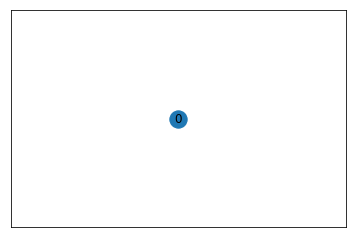

In [9]:
graph_layers = Graph_layers()
graph_layers.display_i_layer(0)

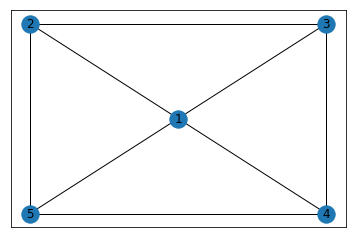

In [10]:
base_node = list(graph_layers.get_layer(0)[0].nodes(data=True))[0]
#indexing from 0 
first_layer_G = graph_layers.get_layer(0)[0].copy()

#apply p1 production
G, i_node = p1(first_layer_G, base_node[0], graph_layers.get_node_id_gen()) 
graph_layers.add_new_layer(G)

graph_layers.display_i_layer(1)

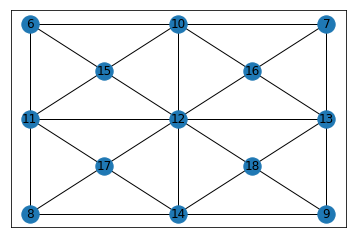

In [11]:
#apply p2 production
G = graph_layers.get_layer(1)[0]
nG = p2(G, 1, graph_layers.get_node_id_gen())
graph_layers.add_new_layer(nG)
graph_layers._layers[2][0].nodes(data=True)
graph_layers.display_i_layer(2)

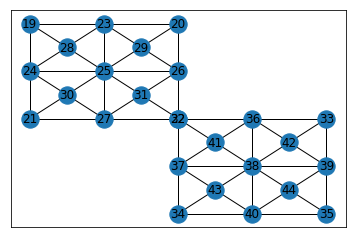

In [12]:
#apply p2 production 4 times
G = graph_layers.get_layer(2)[0]
graph_layers.add_new_layer( p2(G, 15, graph_layers.get_node_id_gen()))
graph_layers.add_to_last_layer(p2(G, 18, graph_layers.get_node_id_gen()))
graph_layers.display_i_layer(3)

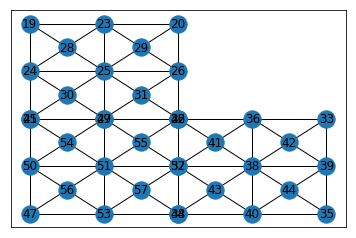

In [13]:
#apply p2 production
G = graph_layers.get_layer(2)[0]
graph_layers.add_to_last_layer(p2(G, 17, graph_layers.get_node_id_gen()))
graph_layers.display_i_layer(3)

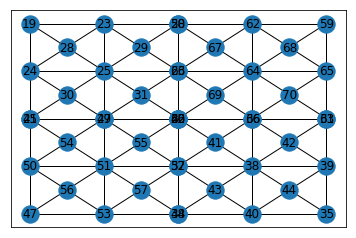

In [14]:
#apply p2 production
G = graph_layers.get_layer(2)[0]
graph_layers.add_to_last_layer(p2(G, 16, graph_layers.get_node_id_gen()))
graph_layers.display_i_layer(3)

In [15]:
#tests for production 1
def test_production_one(zero_layer_G, base_node):   
    #apply p1 production
    G, i_node = p1(zero_layer_G, base_node[0], graph_layers.get_node_id_gen()) 
    assert(G.number_of_nodes() == 5)

    I_node_num = 0
    I_node_id = -1
    E_nodes = []
    for node_id, node_type in nx.get_node_attributes(G, 'type').items():
        if node_type == 'I':
            I_node_num += 1
            assert(G.degree[node_id] ==  4)
            I_node_id = node_id                  
        else:
            assert(G.degree[node_id] == 3)
            assert((node_id, I_node_id) in list(G.edges(node_id)))
            E_nodes.append(node_id)
    
    assert((E_nodes[0], E_nodes[2]) not in list(G.edges))
    assert((E_nodes[1], E_nodes[3]) not in list(G.edges))

    assert(I_node_num == 1)
    
    assert(len(nx.get_node_attributes(G, 'parent')) == 1)
    parent_id = list(nx.get_node_attributes(G, 'parent').items())[0][1]
    node_id_with_parent = list(nx.get_node_attributes(G, 'parent').items())[0][0]
    assert(base_node[0] == parent_id)
    assert(node_id_with_parent == I_node_id)


In [16]:
#correct left side
base_node = list(graph_layers.get_layer(0)[0].nodes(data=True))[0]
zero_layer_G = graph_layers.get_layer(0)[0].copy()
test_production_one(zero_layer_G, base_node)

#empty left side
zero_layer_G  = nx.Graph()
try:
    test_production_one(zero_layer_G, base_node)
except KeyError:
    print("exception when empty first layer occured")

#incorrect label 
zero_layer_G  = nx.Graph()
zero_layer_G.add_nodes_from([(graph_layers.get_node_id_gen()(), {'pos': (0,0),'type': 'I'})])
try:
    test_production_one(zero_layer_G, base_node)
except KeyError:
    print("exception when incorrect label occured")

exception when empty first layer occured
exception when incorrect label occured


In [17]:
#tests for production 2
def test_production_two(first_layer_G, i_node):   
    #apply p2 production
    sec_layer_G = p2(first_layer_G, i_node[0], graph_layers.get_node_id_gen())
    
    assert(G.number_of_nodes() == 13)
    E_nodes_from_layer_1 = [first_layer_G.nodes[node_ID]['pos'] for i_node_ID, node_ID in first_layer_G.edges(i_node[0])]
  
    #check if layer two contains E nodes from layer 1 
    assert(set(E_nodes_from_layer_1).issubset(list(nx.get_node_attributes(sec_layer_G, 'pos').values())))  
    extreme_E_nodes_from_layer_2 = []
       
    for node_id, attr in sec_layer_G.nodes.data():
        if attr['pos'] in E_nodes_from_layer_1:
            extreme_E_nodes_from_layer_2.append((node_id, attr['pos']))
            
    (x_1, y_1) = extreme_E_nodes_from_layer_2[0][1]
    (x_2, y_2) = extreme_E_nodes_from_layer_2[1][1]
    (x_3, y_3) = extreme_E_nodes_from_layer_2[2][1]
    (x_4, y_4) = extreme_E_nodes_from_layer_2[3][1]

    I_nodes_from_layer_2 = []
    for node_id, attr in sec_layer_G.nodes.data():
        if attr['type'] == 'I':
            I_nodes_from_layer_2.append((node_id, attr['pos']))
            assert(attr['parent'] == i_node[0])
            assert(sec_layer_G.degree[node_id] == 4)            
    
    subnet_neighbours = ((1, 2), (0, 3), (0, 3), (2, 1))
    subnets = []
    for i, (node_id, pos) in enumerate(I_nodes_from_layer_2):
        subnet = [node_id for I_node_id, node_id in list(sec_layer_G.edges(node_id))]
        pos = {sec_layer_G.nodes[node_id]['pos']: node_id for node_id in subnet}
        subnets.append(set(pos.items()))
        assert(extreme_E_nodes_from_layer_2[i][0] in subnet)

        extreme_node_id = extreme_E_nodes_from_layer_2[i][0] 
        assert(sec_layer_G.degree[extreme_node_id] == 3)
               
        (x0, y0) = extreme_E_nodes_from_layer_2[i][1]
        (x1, y1) = extreme_E_nodes_from_layer_2[subnet_neighbours[i][0]][1]
        (x2, y2) = extreme_E_nodes_from_layer_2[subnet_neighbours[i][1]][1]

        pos1 = ((x0+x1)/2,(y0+y1)/2)
        assert(len(list(filter(lambda x: math.isclose(x[0],pos1[0]) and math.isclose(x[1],pos1[1]), list(pos.keys())))) == 1)
        node_id = pos[pos1]
        assert(sec_layer_G.degree[node_id] == 5)

        pos2 = ((x0+x2)/2,(y0+y2)/2)
        assert(len(list(filter(lambda x: math.isclose(x[0],pos2[0]) and math.isclose(x[1],pos2[1]), list(pos.keys())))) == 1)
        node_id = pos[pos2]
        assert(sec_layer_G.degree[node_id] == 5)
        
        for node in subnet:
            nghbs = [b_node for (node_id, b_node) in list(sec_layer_G.edges(node))]
            assert(len(set(nghbs).intersection(subnet)) == 2)
        assert((subnet[0], subnet[3]) not in list(sec_layer_G.edges))
        assert((subnet[1], subnet[2]) not in list(sec_layer_G.edges))

        
    #check if central element is valid
    central_elem = subnets[0].intersection(subnets[1], subnets[2], subnets[3])
    assert(len(central_elem) == 1)
    entral_elem_pos = list(central_elem)[0][0]
    assert(entral_elem_pos == ((x_1+x_4)/2, (y_1+y_4)/2))  

In [18]:
#correct
base_node = list(graph_layers.get_layer(0)[0].nodes(data=True))[0]
first_layer_G = graph_layers.get_layer(0)[0].copy()
first_layer_G, i_node = p1(first_layer_G, base_node[0], graph_layers.get_node_id_gen()) 
test_production_two(first_layer_G, i_node)

#without one node
first_layer_G_cp = first_layer_G.copy()
first_layer_G_cp.remove_node(list(first_layer_G_cp.nodes)[0])
try:
    test_production_two(first_layer_G_cp, i_node)
except KeyError:
    print("exception when left side without one node")
    
#as part of bigger graph
first_layer_G_cp = first_layer_G.copy()
first_layer_G_cp.add_nodes_from([(graph_layers.get_node_id_gen()(), {'pos': (-3,3),'type': 'e'})])
test_production_two(first_layer_G_cp, i_node)
    
#without edge
first_layer_G_cp = first_layer_G.copy()
first_layer_G_cp.remove_node(list(first_layer_G_cp.nodes)[1])
first_layer_G_cp.add_nodes_from([(graph_layers.get_node_id_gen()(), {'pos': (-1,1),'type': 'e'})])
try:
    test_production_two(first_layer_G_cp, i_node)
except CannotExecuteProduction:
    print("exception when left side without some edge")
    
#incorrect label
first_layer_G_cp = first_layer_G.copy()
nb1, nb2 = list(first_layer_G_cp.nodes)[0], list(first_layer_G_cp.nodes)[2]
first_layer_G_cp.remove_node(list(first_layer_G_cp.nodes)[1])
new_node_id = graph_layers.get_node_id_gen()()
first_layer_G_cp.add_nodes_from([(new_node_id, {'pos': (-1,1),'type': 'I'})])
first_layer_G_cp.add_edge(new_node_id, nb1)
first_layer_G_cp.add_edge(new_node_id, nb2)

try:
    test_production_two(first_layer_G_cp, i_node)
except CannotExecuteProduction:
    print("exception when left side with incorrect label")


exception when left side without one node
exception when left side without some edge
exception when left side with incorrect label


In [19]:
#
#      I1  - e1    e1 - I3
#        \\  /        \\ /
#         e2          e2
#        / \\         / \\
#     I2  - e3     e3 - I4
#
#              |
#             \\/
#
#      I1  - e1 - I3
#        \\   |   /
#            e2
#        /   |   \\
#     I2  - e3 - I4
def p7(parent_layer, child_layer, base_node_ids, n_id_gen):
    #finding graph in child_layer
    first, second = None, None
    for graph in child_layer:
        if any(item in graph.nodes for item in base_node_ids):
            if second != None:
                raise CannotExecuteProduction
            if first is None:
                first = graph
            else:
                second = graph

    first_i_nodes = get_graph_i_nodes_by_ids(first, base_node_ids)
    second_i_nodes = get_graph_i_nodes_by_ids(second, base_node_ids)

    #checking each I node has a parent
    if not all('parent' in first.node[n] for n in first_i_nodes) or not all('parent' in second.node[n] for n in second_i_nodes):
        raise CannotExecuteProduction

    #finding graph in parent_layer
    parents = get_parent_of_nodes(first, first_i_nodes) + get_parent_of_nodes(second, second_i_nodes)
    if len(parents) != 2:
        raise CannotExecuteProduction
    parent_graphs = [graph for graph in parent_layer if all(parent in graph.nodes for parent in parents)]
    if len(parent_graphs) > 1:
        raise CannotExecuteProduction
    parent_graph = parent_graphs[0]
    if not any(fst for fst in parent_graph.neighbors(parents[0]) for snd in parent_graph.neighbors(parents[1]) if fst == snd):
        raise CannotExecuteProduction

    #finding nodes to reduce
    nodes_to_reduce_all = [(x_n, y_n) 
         for x in first_i_nodes 
         for y in second_i_nodes 
         for x_n in first.neighbors(x) 
         for y_n in second.neighbors(y)
         if 0.1 > get_distance(nx.get_node_attributes(first, 'pos')[x_n], nx.get_node_attributes(second, 'pos')[y_n])]
    nodes_to_reduce = list(set(nodes_to_reduce_all))
    
    if len(nodes_to_reduce_all) != 6 or len(nodes_to_reduce) != 3:
        raise CannotExecuteProduction
    
    possible_edges = [True for (x, _) in nodes_to_reduce for (y, _) in nodes_to_reduce if x != y and first.has_edge(x, y)]
    if len(possible_edges) != 4:
        raise CannotExecuteProduction
    possible_edges = [True for (_, x) in nodes_to_reduce for (_, y) in nodes_to_reduce if x != y and second.has_edge(x, y)]
    if len(possible_edges) != 4:
        raise CannotExecuteProduction
        
    
    #creating new correct graph
    reversed_nodes_to_reduce = [(value, key) for (key, value) in nodes_to_reduce]
    mapping = dict(nodes_to_reduce + reversed_nodes_to_reduce)

    new_old_graph = deepcopy(first)
    second_old_graph = nx.relabel_nodes(second, mapping, copy=True)

    nodes_to_add = [(node, values)
                             for (node, values) in second_old_graph.nodes().items() 
                             if node not in mapping.keys()]

    new_old_graph.add_nodes_from(nodes_to_add)
    new_old_graph.add_edges_from(second_old_graph.edges)

    i_nodes = get_graph_i_nodes(new_old_graph)

    return i_nodes, new_old_graph, [first, second]

In [20]:
def apply_P7(parent_layer, child_layer, base_node_ids, n_id_gen):
    i_nodes, new_graph, old_graphs = p7(parent_layer, child_layer, base_node_ids, n_id_gen)
    for graph in old_graphs:
        child_layer.remove(graph)
    child_layer.append(new_graph)

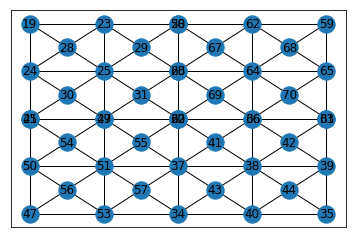

In [21]:
apply_P7(graph_layers.get_layer(2), graph_layers.get_layer(3), [41, 43, 55, 57], graph_layers.get_node_id_gen())
graph_layers.display_i_layer(3)

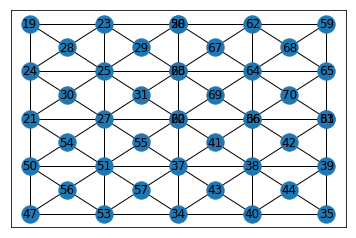

In [22]:
apply_P7(graph_layers.get_layer(2), graph_layers.get_layer(3), [30, 31, 55, 54], graph_layers.get_node_id_gen())
graph_layers.display_i_layer(3)

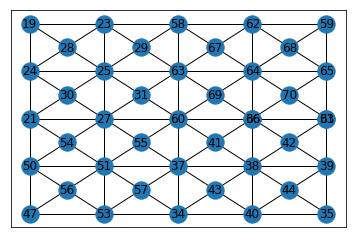

In [23]:
apply_P7(graph_layers.get_layer(2), graph_layers.get_layer(3), [29, 31, 67, 69], graph_layers.get_node_id_gen())
graph_layers.display_i_layer(3)

In [24]:
def create_leaf_edges(parent, id_gen, offset, tiny_offset):
    center_x, center_y = 2, 2
    l2 = nx.Graph()
    l2_edges = []
    l2_nodes = []
    upper_i = (id_gen.get_id(), {'pos': (center_x + offset, center_y + 1),'type': 'I', 'parent': parent[0]})
    lower_i = (id_gen.get_id(), {'pos': (center_x + offset, center_y - 1),'type': 'I', 'parent': parent[0]})
    l2_nodes.extend([upper_i, lower_i])

    a_upper_e = (id_gen.get_id(), {'pos': (center_x + tiny_offset, center_y + 1.5),'type': 'e'})
    a_mid_e = (id_gen.get_id(), {'pos': (center_x + tiny_offset, center_y),'type': 'e'})
    a_lower_e = (id_gen.get_id(), {'pos': (center_x + tiny_offset, center_y - 1.5),'type': 'e'})
    b_upper_e = (id_gen.get_id(), {'pos': (center_x + 2*offset, center_y + 1.5),'type': 'e'})
    b_mid_e = (id_gen.get_id(), {'pos': (center_x + 2*offset, center_y),'type': 'e'})
    b_lower_e = (id_gen.get_id(), {'pos': (center_x + 2*offset, center_y - 1.5),'type': 'e'})

    l2_nodes.extend([a_upper_e, a_mid_e, a_lower_e, b_upper_e, b_mid_e, b_lower_e])
    l2_edges.extend([(a_upper_e[0], a_mid_e[0]), 
                     (a_lower_e[0], a_mid_e[0]), 
                     (a_lower_e[0], lower_i[0]),
                     (lower_i[0], a_mid_e[0]),
                     (upper_i[0], a_mid_e[0]),
                     (upper_i[0], a_upper_e[0]),
                     (b_upper_e[0], b_mid_e[0]), 
                     (b_lower_e[0], b_mid_e[0]), 
                     (b_lower_e[0], lower_i[0]),
                     (lower_i[0], b_mid_e[0]),
                     (upper_i[0], b_mid_e[0]),
                     (upper_i[0], b_upper_e[0]),
                     (b_upper_e[0], a_upper_e[0]),
                     (b_mid_e[0], a_mid_e[0]),
                     (b_lower_e[0], a_lower_e[0])])

    l2.add_nodes_from(l2_nodes)
    l2.add_edges_from(l2_edges)
    return l2, [lower_i[0], upper_i[0]]

In [25]:

def create_valid_input_net():
    graph_layers = Graph_layers()
    side_len=2
    parent_node_x, parent_node_y = 1, 1
    id_gen = graph_layers.get_node_id_gen()
    parent_node = (id_gen.get_id(), {'pos': (parent_node_x, parent_node_y), 'type': 'E','parent': -1})

    half_side_len = side_len/2
    i_nodes = [
        (id_gen.get_id(), {'pos': (parent_node_x + half_side_len, parent_node_y - half_side_len),'type': 'I', 'parent': parent_node[0]}),
        (id_gen.get_id(), {'pos': (parent_node_x - half_side_len, parent_node_y - half_side_len),'type': 'I', 'parent': parent_node[0]})
    ]
    l1_edges = []
    for i_node in i_nodes:
         l1_edges.extend([(i_node[0],parent_node[0])])

    l1 = nx.Graph()
    l1.add_nodes_from([parent_node])
    l1.add_nodes_from(i_nodes)
    l1.add_edges_from(l1_edges)
    graph_layers.add_new_layer(l1)

    center_x, center_y, offset, tiny_offset = 2, 2, -1, -0.05
    left_graph, output_ids = create_leaf_edges(i_nodes[0], id_gen, offset, tiny_offset)
    graph_layers.add_new_layer(left_graph)
    offset = -offset
    tiny_offset = -tiny_offset
    right_graph, right_ids = create_leaf_edges(i_nodes[1], id_gen, offset, tiny_offset)
    graph_layers.add_to_layer(2, right_graph)
    output_ids.extend(right_ids)

    return graph_layers, output_ids



In [26]:
# obraz pogladowy jasne jest ze istnieja 4 permutacje izomorficzne jesli chodzi o labelkowanie wierzcholkow
#     e0 - - - e1
#      | \    / |
#     e4   I0   |
#      | /   \  |
#     e2 - - - e3
#
#          |
#         \/
#
#     e0' - - - n0 - - - e1'
#     | \    / | \    / |
#     |  I1    |  I2    |
#     | /   \  | /   \  |
#    e4' - - - n2 - - - n3
#     | \    / | \    / |
#     |  I3    |  I4    |
#     | /   \  | /   \  |
#    e2' - - - n4 - - - e3'
def p3(G, base_node_id, n_id_gen):
    if not (G.nodes[base_node_id]['type'].lower() == 'i'): raise CannotExecuteProduction
    nG = nx.Graph()
    es = list(G.neighbors(base_node_id))
    nghs_counter = Counter(reduce(lambda a,b : a+b ,[list(G.neighbors(e)) for e in es],es + [base_node_id]))
    es1 = set([x for x, count in nghs_counter.items() if count >= 2]) - {base_node_id}
    if len(es) != 4 and len(es1) != 5:
        raise CannotExecuteProduction
    e0, e1, e2, e3, e4 = None, None, None, None, None
    baseX, baseY = G.nodes[base_node_id]['pos']
    
    
    # get Square corners
    for ex in es:
        x,y = G.nodes[ex]['pos']
        if x<baseX:
            if y<baseY:
                e2= (ex,G.nodes[ex])
            if y>baseY:
                e0= (ex,G.nodes[ex])
        else:
            if y<baseY:
                e3= (ex,G.nodes[ex])
            if y>baseY:
                e1= (ex,G.nodes[ex])
    if not all([e0,e1,e2,e3]): raise CannotExecuteProduction
    ids = [base_node_id, e0[0], e1[0], e2[0], e3[0]]

    edge0 = G.has_edge(e0[0],e1[0])
    edge1 = G.has_edge(e0[0],e2[0])
    edge2 = G.has_edge(e2[0],e3[0])
    edge3 = G.has_edge(e1[0],e3[0])
    
    # should be 3 edges between 4 cornesrs (1 is created with extra node)
    if(int(edge0) + int(edge1) + int(edge2) + int(edge3) != 3):
         raise CannotExecuteProduction
           
    def getNodeBetween(e1Id, e2Id):
        allNodes = list(G.neighbors(e1Id)) + list(G.neighbors(e2Id))
        possibleNodes = [n for n in allNodes if n in list(G.neighbors(e1Id)) and n in list(G.neighbors(e2Id))]
        return list(set(possibleNodes))
    
    if(not edge0):
        possE4 = getNodeBetween(e0[0],e1[0])
    if(not edge1):
        possE4 = getNodeBetween(e0[0],e2[0])
    if(not edge2):
        possE4 = getNodeBetween(e2[0],e3[0])
    if(not edge3):
        possE4 = getNodeBetween(e1[0],e3[0])
 
    # get all 'e' nodes between two nodes that does not share edge
    maybeE4 = [ G.nodes[e] for e in possE4 if G.nodes[e]['type'].lower() == 'e']
    if(len(maybeE4) != 1):
        raise CannotExecuteProduction
    
    # this is the extra node
    e4 = maybeE4[0]

    #check if node has proper cordinates
    if(not edge0):
        if(e4['pos'] != avg_pos(e0[1]['pos'], e1[1]['pos'])):
            raise CannotExecuteProduction
    if(not edge1):
        if(e4['pos'] != avg_pos(e0[1]['pos'], e2[1]['pos'])):
            raise CannotExecuteProduction
    if(not edge2):
        if(e4['pos'] != avg_pos(e2[1]['pos'], e3[1]['pos'])):
            raise CannotExecuteProduction
    if(not edge3):
        if(e4['pos'] != avg_pos(e1[1]['pos'], e3[1]['pos'])):
            raise CannotExecuteProduction
                                                                                     
    e0 = (n_id_gen(),{'pos': e0[1]['pos'],'type' : e0[1]['type']})
    e1 = (n_id_gen(),{'pos': e1[1]['pos'],'type' : e1[1]['type']})
    e2 = (n_id_gen(),{'pos': e2[1]['pos'],'type' : e2[1]['type']})
    e3 = (n_id_gen(),{'pos': e3[1]['pos'],'type' : e3[1]['type']})

    n0 = (n_id_gen(),{'pos' : avg_pos(e0[1]['pos'],e1[1]['pos']),'type':'e'})
    n1 = (n_id_gen(),{'pos' : avg_pos(e0[1]['pos'],e2[1]['pos']),'type':'e'})
    n2 = (n_id_gen(),{'pos' : avg_pos(e1[1]['pos'],e2[1]['pos']),'type':'e'})
    n3 = (n_id_gen(),{'pos' : avg_pos(e1[1]['pos'],e3[1]['pos']),'type':'e'})
    n4 = (n_id_gen(),{'pos' : avg_pos(e2[1]['pos'],e3[1]['pos']),'type':'e'})
    
    I1 = (n_id_gen(),{'pos' : avg_pos(e0[1]['pos'],n2[1]['pos']),'type':'I','parent':base_node_id})
    I2 = (n_id_gen(),{'pos' : avg_pos(e1[1]['pos'],n2[1]['pos']),'type':'I','parent':base_node_id})
    I3 = (n_id_gen(),{'pos' : avg_pos(e2[1]['pos'],n2[1]['pos']),'type':'I','parent':base_node_id})
    I4 = (n_id_gen(),{'pos' : avg_pos(e3[1]['pos'],n2[1]['pos']),'type':'I','parent':base_node_id})
    # add all new edges
    new_edges = [
        (e0[0],n0[0]),(n0[0],e1[0]),
        (e0[0],I1[0]),(n0[0],I1[0]), (n0[0],I2[0]),(e1[0],I2[0]),
        (e0[0],n1[0]),(n0[0],n2[0]),(e1[0],n3[0]),
        (n1[0],I1[0]),(n2[0],I1[0]), (n2[0],I2[0]),(n3[0],I2[0]),
        (n1[0],n2[0]),(n2[0],n3[0]),
        (n1[0],I3[0]),(n2[0],I3[0]), (n2[0],I4[0]),(n3[0],I4[0]),
        (n1[0],e2[0]),(n2[0],n4[0]),(n3[0],e3[0]),
        (e2[0],I3[0]),(n4[0],I3[0]), (n4[0],I4[0]),(e3[0],I4[0]),
        (e2[0],n4[0]),(n4[0],e3[0]),
    ]
    nG.add_nodes_from([e0,e1,e2,e3,n0,n1,n2,n3,n4,I1,I2,I3,I4])
    nG.add_edges_from(new_edges)
    return nG


In [27]:
# obraz pogladowy jasne jest ze istnieja 4 permutacje izomorficzne jesli chodzi o labelkowanie wierzcholkow
#     e0 - e5 - e1
#      | \    / |
#     e4   I0   |
#      | /   \  |
#     e2 - - - e3
#
#          |
#         \/
#
#     e0' - - - n0 - - - e1'
#     | \    / | \    / |
#     |  I1    |  I2    |
#     | /   \  | /   \  |
#    e4' - - - n2 - - - n3
#     | \    / | \    / |
#     |  I3    |  I4    |
#     | /   \  | /   \  |
#    e2' - - - n4 - - - e3'
def p4(G, base_node_id, n_id_gen):
    if not (G.nodes[base_node_id]['type'].lower() == 'i'): raise CannotExecuteProduction
    nG = nx.Graph()
    es = list(G.neighbors(base_node_id))
    nghs_counter = Counter(reduce(lambda a,b : a+b ,[list(G.neighbors(e)) for e in es],es + [base_node_id]))
    es1 = set([x for x, count in nghs_counter.items() if count >= 2]) - {base_node_id}
    if len(es) != 4 and len(es1) != 6:
        raise CannotExecuteProduction
    e0, e1, e2, e3, e4, e5 = None, None, None, None, None, None
    baseX, baseY = G.nodes[base_node_id]['pos']
    
    
    # get Square corners
    for ex in es:
        x,y = G.nodes[ex]['pos']
        if x<baseX:
            if y<baseY:
                e2= (ex,G.nodes[ex])
            if y>baseY:
                e0= (ex,G.nodes[ex])
        else:
            if y<baseY:
                e3= (ex,G.nodes[ex])
            if y>baseY:
                e1= (ex,G.nodes[ex])
    if not all([e0,e1,e2,e3]): raise CannotExecuteProduction
    ids = [base_node_id, e0[0], e1[0], e2[0], e3[0]]

    edge0 = G.has_edge(e0[0],e1[0])
    edge1 = G.has_edge(e0[0],e2[0])
    edge2 = G.has_edge(e2[0],e3[0])
    edge3 = G.has_edge(e1[0],e3[0])
    
    # should be 3 edges between 4 cornesrs (1 is created with extra node)
    if(int(edge0) + int(edge1) + int(edge2) + int(edge3) != 2):
         raise CannotExecuteProduction
    # 'edges' with addtional node may lay near each other (cannot be on the other side of square)
    if(int(edge0) + int(edge2) == 2):
        raise CannotExecuteProduction
    if(int(edge1) + int(edge3) == 2):
        raise CannotExecuteProduction
           
    def getNodeBetween(e1Id, e2Id):
        allNodes = list(G.neighbors(e1Id)) + list(G.neighbors(e2Id))
        possibleNodes = [n for n in allNodes if n in list(G.neighbors(e1Id)) and n in list(G.neighbors(e2Id))]
        return list(set(possibleNodes))
    
    possE4andE5 = list([])
    if(not edge0):
        possE4andE5 = possE4andE5 + getNodeBetween(e0[0],e1[0])
    if(not edge1):
        possE4andE5 = possE4andE5 + getNodeBetween(e0[0],e2[0])
    if(not edge2):
        possE4andE5 = possE4andE5 + getNodeBetween(e2[0],e3[0])
    if(not edge3):
        possE4andE5 = possE4andE5 + getNodeBetween(e1[0],e3[0])
 
    # get all 'e' nodes between two nodes that does not share edge
    maybeE4AndE5 = [ G.nodes[e] for e in possE4andE5 if G.nodes[e]['type'].lower() == 'e']
    if(len(maybeE4AndE5) != 2):
        raise CannotExecuteProduction
    
    # these are the extra nodes
    e4 = maybeE4AndE5[0]
    e5 = maybeE4AndE5[0]
    
    def checkIfHasOneOfProperPositionsOrRaise(e):
        proper = False
        if(not edge0):
            if(e['pos'] == avg_pos(e0[1]['pos'], e1[1]['pos'])):
                proper = True
        if(not edge1):
            if(e['pos'] != avg_pos(e0[1]['pos'], e2[1]['pos'])):
                proper = True
        if(not edge2):
            if(e['pos'] != avg_pos(e2[1]['pos'], e3[1]['pos'])):
                proper = True
        if(not edge3):
            if(e['pos'] != avg_pos(e1[1]['pos'], e3[1]['pos'])):
                proper = True
        if(not proper):
            raise CannotExecuteProduction
        
    
    #check if node has proper cordinates
    checkIfHasOneOfProperPositionsOrRaise(e4)
    checkIfHasOneOfProperPositionsOrRaise(e5)
    
    e0 = (n_id_gen(),{'pos': e0[1]['pos'],'type' : e0[1]['type']})
    e1 = (n_id_gen(),{'pos': e1[1]['pos'],'type' : e1[1]['type']})
    e2 = (n_id_gen(),{'pos': e2[1]['pos'],'type' : e2[1]['type']})
    e3 = (n_id_gen(),{'pos': e3[1]['pos'],'type' : e3[1]['type']})

    n0 = (n_id_gen(),{'pos' : avg_pos(e0[1]['pos'],e1[1]['pos']),'type':'e'})
    n1 = (n_id_gen(),{'pos' : avg_pos(e0[1]['pos'],e2[1]['pos']),'type':'e'})
    n2 = (n_id_gen(),{'pos' : avg_pos(e1[1]['pos'],e2[1]['pos']),'type':'e'})
    n3 = (n_id_gen(),{'pos' : avg_pos(e1[1]['pos'],e3[1]['pos']),'type':'e'})
    n4 = (n_id_gen(),{'pos' : avg_pos(e2[1]['pos'],e3[1]['pos']),'type':'e'})
    
    I1 = (n_id_gen(),{'pos' : avg_pos(e0[1]['pos'],n2[1]['pos']),'type':'I','parent':base_node_id})
    I2 = (n_id_gen(),{'pos' : avg_pos(e1[1]['pos'],n2[1]['pos']),'type':'I','parent':base_node_id})
    I3 = (n_id_gen(),{'pos' : avg_pos(e2[1]['pos'],n2[1]['pos']),'type':'I','parent':base_node_id})
    I4 = (n_id_gen(),{'pos' : avg_pos(e3[1]['pos'],n2[1]['pos']),'type':'I','parent':base_node_id})
    # add all new edges
    new_edges = [
        (e0[0],n0[0]),(n0[0],e1[0]),
        (e0[0],I1[0]),(n0[0],I1[0]), (n0[0],I2[0]),(e1[0],I2[0]),
        (e0[0],n1[0]),(n0[0],n2[0]),(e1[0],n3[0]),
        (n1[0],I1[0]),(n2[0],I1[0]), (n2[0],I2[0]),(n3[0],I2[0]),
        (n1[0],n2[0]),(n2[0],n3[0]),
        (n1[0],I3[0]),(n2[0],I3[0]), (n2[0],I4[0]),(n3[0],I4[0]),
        (n1[0],e2[0]),(n2[0],n4[0]),(n3[0],e3[0]),
        (e2[0],I3[0]),(n4[0],I3[0]), (n4[0],I4[0]),(e3[0],I4[0]),
        (e2[0],n4[0]),(n4[0],e3[0]),
    ]
    nG.add_nodes_from([e0,e1,e2,e3,n0,n1,n2,n3,n4,I1,I2,I3,I4])
    nG.add_edges_from(new_edges)
    return nG

p3 simple graph
Trying to use p4 on p3 graph
CannotExecuteProduction exception caught


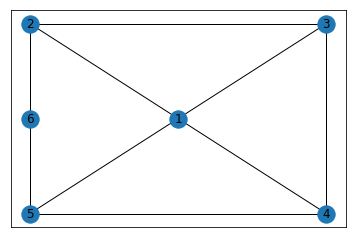

Applying p3 production


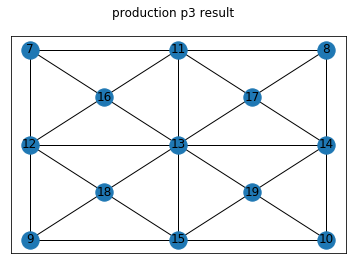

Success

p4 simple graph
Trying to use p3 on p4 graph
CannotExecuteProduction exception caught


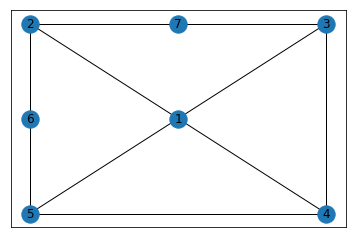

Applying p4 production


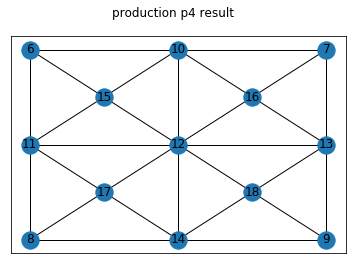

Success

p3 not so simple graph
Trying to use p3 on p4 graph
CannotExecuteProduction exception caught


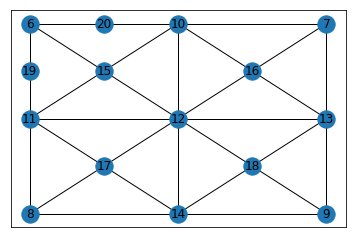

Applying p4 production


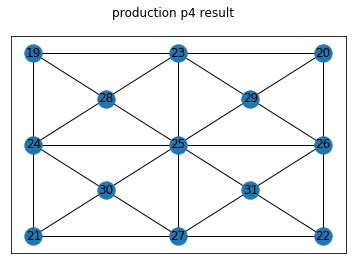

Success

p4 not so simple graph
Trying to use p4 on p3 graph
CannotExecuteProduction exception caught


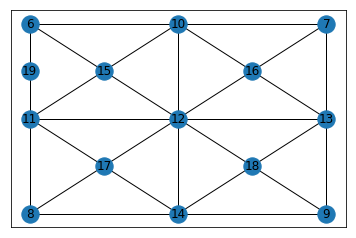

Applying p3 production


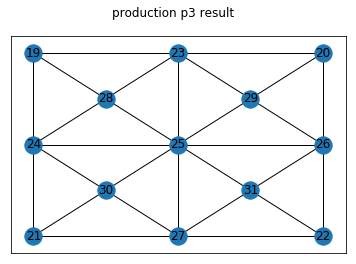

Success

shuffle with node removal
node removal
p3 ran


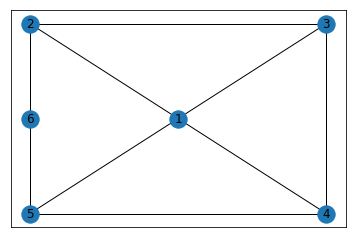

p3 ran


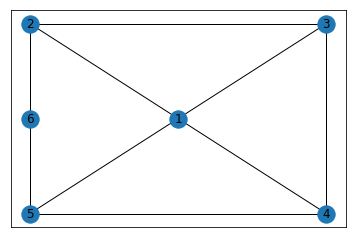

p3 ran


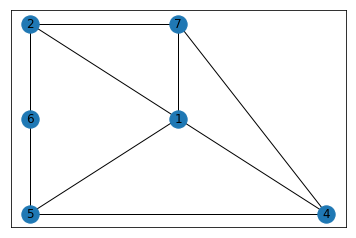

p3 ran


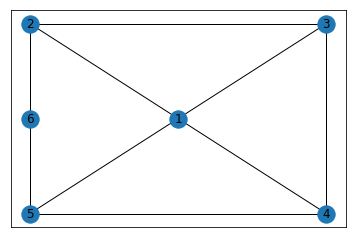

p3 ran


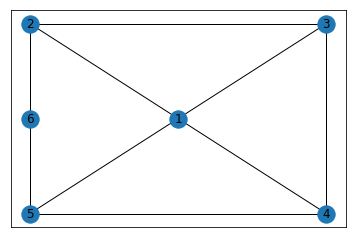

p3 ran


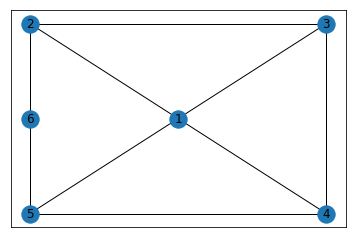

p3 ran


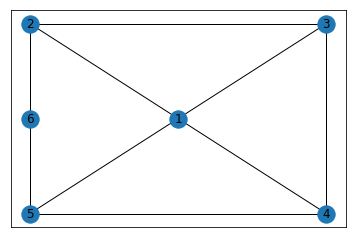

edge removal
edge removal and node removal
shuffle only
node removal shuffle and random offset
edge removal shuffle and random offset
node removal edge removal shuffle and random offset
Has any p3 ran?: True
Has any p4 ran?: False


In [28]:
def zad_2_tests():
    
    def print_res(graph_layers,prod_f, prod,start_layer):
        fig1 = plt.figure(1)
        graph_layers.display_i_layer(start_layer)
        fig1.suptitle(f'base {prod} graph')
        plt.show()
        print(f'Applying {prod} production')
        graph_layers.add_new_layer(prod_f())
        fig2 = plt.figure(2)
        fig2.suptitle(f'production {prod} result')
        graph_layers.display_i_layer(start_layer+1)
        plt.show()
        print('Success')
        print()
    
    def prepare_graph(f=None):
        graph_layers = Graph_layers()
        base_node = list(graph_layers.get_layer(0)[0].nodes(data=True))[0]
        first_layer_G = graph_layers.get_layer(0)[0].copy()
        if f:
            G, i_node = f(first_layer_G, base_node[0], graph_layers.get_node_id_gen())
            graph_layers.add_new_layer(G)
        else:
            G, i_node = p1(first_layer_G, base_node[0], graph_layers.get_node_id_gen()) 
            graph_layers.add_new_layer(G)
            G = graph_layers.get_layer(1)[0]
            G = p2(G, 1, graph_layers.get_node_id_gen())
            graph_layers.add_new_layer(G)
            graph_layers._layers[2][0].nodes(data=True)
        return graph_layers,G,i_node
        
        
    def pX1(G, base_node_id, n_id_gen, side_len=2, max_random_offset = 0):
        assert(G.nodes[base_node_id]['type'].lower() == 'e' )
        assert(len(G.nodes)==1)
        all_new_nodes = []
        all_new_edges = []
        base_pos = G.nodes[base_node_id]['pos']
        x_offset = ((np.random.random()-0.5) * max_random_offset * 2)
        y_offset = ((np.random.random()-0.5) * max_random_offset * 2)
        i_node_x, i_node_y = base_pos[0], base_pos[1]
        i_node = (n_id_gen(), {'pos': (i_node_x+x_offset, i_node_y-y_offset), 'type': 'I','parent': -1})
        all_new_nodes.append(i_node)

        half_side_len = side_len/2
        e_nodes = [
            (n_id_gen(), {'pos': (i_node_x - half_side_len, i_node_y + half_side_len),'type': 'e'}),
            (n_id_gen(), {'pos': (i_node_x + half_side_len, i_node_y + half_side_len),'type': 'e'}),
            (n_id_gen(), {'pos': (i_node_x + half_side_len, i_node_y - half_side_len),'type': 'e'}),
            (n_id_gen(), {'pos': (i_node_x - half_side_len, i_node_y - half_side_len),'type': 'e'}),
            (n_id_gen(), {'pos': (i_node_x - half_side_len, i_node_y),'type': 'e'})
        ]
        for i in range(len(e_nodes)):
            all_new_edges.extend([(e_nodes[i][0],e_nodes[i+1 if i + 1 < len(e_nodes) else 0][0])])
            if i < 4:
                all_new_edges.extend([(i_node[0],e_nodes[i][0])])
        
        all_new_nodes.extend(e_nodes)
        nG = nx.Graph()
        nG.add_nodes_from(all_new_nodes)
        nG.add_edges_from(all_new_edges)
        return nG, i_node
    
    def pX2(G, base_node_id, n_id_gen, side_len=2, max_random_offset = 0):
        assert(G.nodes[base_node_id]['type'].lower() == 'e' )
        assert(len(G.nodes)==1)
        all_new_nodes = []
        all_new_edges = []
        base_pos = G.nodes[base_node_id]['pos']
        x_offset = ((np.random.random()-0.5) * max_random_offset * 2)
        y_offset = ((np.random.random()-0.5) * max_random_offset * 2)
        i_node_x, i_node_y = base_pos[0], base_pos[1]
        i_node = (n_id_gen(), {'pos': (i_node_x+x_offset, i_node_y-y_offset), 'type': 'I','parent': -1})
        all_new_nodes.append(i_node)

        half_side_len = side_len/2
        e_nodes = [
            (n_id_gen(), {'pos': (i_node_x - half_side_len, i_node_y + half_side_len),'type': 'e'}),
            (7, {'pos': (i_node_x, i_node_y + half_side_len),'type': 'e'}),
            (n_id_gen(), {'pos': (i_node_x + half_side_len, i_node_y + half_side_len),'type': 'e'}),
            (n_id_gen(), {'pos': (i_node_x + half_side_len, i_node_y - half_side_len),'type': 'e'}),
            (n_id_gen(), {'pos': (i_node_x - half_side_len, i_node_y - half_side_len),'type': 'e'}),
            (6, {'pos': (i_node_x - half_side_len, i_node_y),'type': 'e'})
        ]
        for i in range(len(e_nodes)):
            all_new_edges.extend([(e_nodes[i][0],e_nodes[i+1 if i + 1 < len(e_nodes) else 0][0])])
            if i != 1 and i != 5:
                all_new_edges.extend([(i_node[0],e_nodes[i][0])])

        all_new_nodes.extend(e_nodes)
        nG = nx.Graph()
        nG.add_nodes_from(all_new_nodes)
        nG.add_edges_from(all_new_edges)
        return nG, i_node
    
    #TC1
    print('p3 simple graph')
    graph_layers, G, i_node = prepare_graph(pX1)
    
    print("Trying to use p4 on p3 graph")
    try:
        p4(G, i_node[0], graph_layers.get_node_id_gen()) 
    except CannotExecuteProduction:
        print("CannotExecuteProduction exception caught")
    else:
        print("Production ran on invalid graph")

    print_res(graph_layers,lambda :p3(G, i_node[0], graph_layers.get_node_id_gen()),'p3',1)
    
    #TC2
    print('p4 simple graph')
    graph_layers, G, i_node = prepare_graph(pX2)
    
    print("Trying to use p3 on p4 graph")
    try:
        p3(G, i_node[0], graph_layers.get_node_id_gen()) 
    except CannotExecuteProduction:
        print("CannotExecuteProduction exception caught")
    else:
        print("Production ran on invalid graph")
        
    print_res(graph_layers,lambda :p4(G, i_node[0], graph_layers.get_node_id_gen()), 'p4',1)
    
    #TC3
    print('p3 not so simple graph')
    graph_layers, G, i_node = prepare_graph()
    rm_edge_if_exists(G, 6, 11)
    rm_edge_if_exists(G, 6, 10)
    n6 = list(G.nodes(data=True))[0]
    n10 = list(G.nodes(data=True))[4]
    n11 = list(G.nodes(data=True))[5]
    n19 = (19, {'pos' : avg_pos(n6[1]['pos'],n11[1]['pos']),'type':'e'})
    n20 = (20, {'pos' : avg_pos(n6[1]['pos'],n10[1]['pos']),'type':'e'})
    G.add_nodes_from([n19, n20])
    G.add_edges_from([(n6[0], n19[0]), (n19[0], n11[0]), (n20[0], n6[0]), (n10[0], n20[0])])
    
    print("Trying to use p3 on p4 graph")
    try:
        p3(G, 15, graph_layers.get_node_id_gen())
    except CannotExecuteProduction:
        print("CannotExecuteProduction exception caught")
    else:
        print("Production ran on invalid graph")
    
    print_res(graph_layers,lambda :p4(G, 15, graph_layers.get_node_id_gen()),'p4',2)
    
    #TC4
    print('p4 not so simple graph')
    graph_layers, G, i_node = prepare_graph()
    rm_edge_if_exists(G, 6, 11)
    n6 = list(G.nodes(data=True))[0]
    n11 = list(G.nodes(data=True))[5]
    n19 = (19, {'pos' : avg_pos(n6[1]['pos'],n11[1]['pos']),'type':'e'})
    G.add_nodes_from([n19])
    G.add_edges_from([(n6[0], n19[0]), (n19[0], n11[0])])
    
    print("Trying to use p4 on p3 graph")
    try:
        p4(G, 15, graph_layers.get_node_id_gen())
    except CannotExecuteProduction:
        print("CannotExecuteProduction exception caught")
    else:
        print("Production ran on invalid graph")
    
    print_res(graph_layers, lambda :p3(G, 15, graph_layers.get_node_id_gen()),'p3',2)
    
    #TESTS ON BROKEN GRAPHS
    np.random.seed(2137)
    def generate_random_graph(G, base_node_id, n_id_gen, side_len=2, prob_of_node_removal=0, shuffle=True, prob_of_edge_removal=0, offset_multi=0):
        assert(G.nodes[base_node_id]['type'].lower() == 'e' )
        assert(len(G.nodes)==1)
        all_new_nodes = []
        all_new_edges = []
        base_pos = G.nodes[base_node_id]['pos']
        x_offset = 0
        y_offset = 0
        i_node_x, i_node_y = base_pos[0], base_pos[1]
        i_node = (n_id_gen(), {'pos': (i_node_x+x_offset, i_node_y-y_offset), 'type': 'I','parent': -1})
        all_new_nodes.append(i_node)

        half_side_len = side_len/2
        
        def random_offset(base_val):
            return base_val + np.sign(base_val) * offset_multi * ((np.random.random()-0.5) * 2)
                
        e_nodes = [
            (n_id_gen(), {'pos': (i_node_x + random_offset(- half_side_len), i_node_y + random_offset(half_side_len)),'type': 'e'}),
            (n_id_gen(), {'pos': (i_node_x + random_offset(half_side_len), i_node_y + random_offset(half_side_len)),'type': 'e'}),
            (n_id_gen(), {'pos': (i_node_x + random_offset(half_side_len), i_node_y + random_offset(- half_side_len)),'type': 'e'}),
            (n_id_gen(), {'pos': (i_node_x + random_offset(- half_side_len), i_node_y + random_offset(- half_side_len)),'type': 'e'}),
            (n_id_gen(), {'pos': (i_node_x + random_offset(- half_side_len), i_node_y),'type': 'e'})
        ] if np.random.uniform(0,1,1)[0] > 0.5 else [
            (n_id_gen(), {'pos': (i_node_x + random_offset(- half_side_len), i_node_y + random_offset(half_side_len)),'type': 'e'}),
            (7, {'pos': (i_node_x, i_node_y + random_offset(half_side_len)),'type': 'e'}),
            (n_id_gen(), {'pos': (i_node_x + random_offset(half_side_len), i_node_y + random_offset(half_side_len)),'type': 'e'}),
            (n_id_gen(), {'pos': (i_node_x + random_offset(half_side_len), i_node_y + random_offset(- half_side_len)),'type': 'e'}),
            (n_id_gen(), {'pos': (i_node_x + random_offset(- half_side_len), i_node_y + random_offset(- half_side_len)),'type': 'e'}),
            (6, {'pos': (i_node_x - half_side_len, i_node_y),'type': 'e'})
        ]
        
        if shuffle: np.random.shuffle(e_nodes)
        e_nodes = [ b for a,b in zip(np.random.uniform(0,1,len(e_nodes)) >= prob_of_node_removal, e_nodes) if a]
        for i in range(len(e_nodes)):
            all_new_edges.extend([(e_nodes[i][0],e_nodes[i+1 if i + 1 < len(e_nodes) else 0][0])])
            if i < 4:
                all_new_edges.extend([(i_node[0],e_nodes[i][0])])
                
        all_new_edges= [ b for a,b in zip(np.random.uniform(0,1,len(all_new_edges)) >= prob_of_edge_removal, all_new_edges) if a]
        all_new_nodes.extend(e_nodes)
        nG = nx.Graph()
        nG.add_nodes_from(all_new_nodes)
        nG.add_edges_from(all_new_edges)
        return nG, i_node
    
    def test_on_broken_graph(show_random,random_res_p3,random_res_p4,graph_layers, G, i_node):
        if show_random:
            graph_layers.display_i_layer(-1)
            plt.show()
        try:
            p3(G, i_node[0], graph_layers.get_node_id_gen())
            random_res_p3 += [True]
            print('p3 ran')
            graph_layers.display_i_layer(-1)
            plt.show()
        except CannotExecuteProduction:
            random_res_p3 += [False]
        try:
            p4(G, i_node[0], graph_layers.get_node_id_gen())
            random_res_p4 += [True]
            print('p4 ran')
            graph_layers.display_i_layer(-1)
            plt.show()
        except CannotExecuteProduction:
            random_res_p4 += [False]
    
    show_random = False
    random_res_p3 = []
    random_res_p4 = []

    print('shuffle with node removal')
    for _ in range(100):
        graph_layers, G, i_node = prepare_graph(lambda a,b,c: generate_random_graph(a,b,c,prob_of_node_removal=0.6))
        test_on_broken_graph(show_random,random_res_p3,random_res_p4,graph_layers,G,i_node)
    print('node removal')
    for _ in range(100):
        graph_layers, G, i_node = prepare_graph(lambda a,b,c: generate_random_graph(a,b,c,prob_of_node_removal=0.4,shuffle=False))
        test_on_broken_graph(show_random,random_res_p3,random_res_p4,graph_layers,G,i_node)
    print('edge removal')
    for _ in range(100):
        graph_layers, G, i_node = prepare_graph(lambda a,b,c: generate_random_graph(a,b,c,prob_of_edge_removal=0.5,shuffle=False))
        test_on_broken_graph(show_random,random_res_p3,random_res_p4,graph_layers,G,i_node)
    print('edge removal and node removal')    
    for _ in range(100):
        graph_layers, G, i_node = prepare_graph(lambda a,b,c: generate_random_graph(a,b,c,prob_of_edge_removal=0.5,prob_of_node_removal=0.5,shuffle=False))
        test_on_broken_graph(show_random,random_res_p3,random_res_p4,graph_layers,G,i_node)
        
####
    print('shuffle only')
    for _ in range(100):
        graph_layers, G, i_node = prepare_graph(generate_random_graph)
        test_on_broken_graph(show_random,random_res_p3,random_res_p4,graph_layers,G,i_node)
    print('node removal shuffle and random offset')
    for _ in range(100):
        graph_layers, G, i_node = prepare_graph(lambda a,b,c: generate_random_graph(a,b,c,prob_of_node_removal=0.6,shuffle=True,offset_multi=1))
        test_on_broken_graph(show_random,random_res_p3,random_res_p4,graph_layers,G,i_node)
    print('edge removal shuffle and random offset')
    for _ in range(100):
        graph_layers, G, i_node = prepare_graph(lambda a,b,c: generate_random_graph(a,b,c,prob_of_edge_removal=0.5,shuffle=True,offset_multi=1))
        test_on_broken_graph(show_random,random_res_p3,random_res_p4,graph_layers,G,i_node)
    print('node removal edge removal shuffle and random offset')
    for _ in range(100):
        graph_layers, G, i_node = prepare_graph(lambda a,b,c: generate_random_graph(a,b,c,prob_of_edge_removal=0.5,prob_of_node_removal=0.5,shuffle=True,offset_multi=1))
        test_on_broken_graph(show_random,random_res_p3,random_res_p4,graph_layers,G,i_node)
            
            
    p3_res = any(random_res_p3)
    p4_res = any(random_res_p4)
    print(f'Has any p3 ran?: {p3_res}')
    print(f'Has any p4 ran?: {p4_res}')

    
zad_2_tests()


In [29]:
import unittest
import random

class TestNotebook(unittest.TestCase):

    def create_valid_output_layer(self):
        graph_layers = Graph_layers()
        id_gen = graph_layers.get_node_id_gen()
        l2 = nx.Graph()
        l2_edges = []
        l2_nodes = []
        center_x, center_y, offset, = 2, 2, -1
        upper_i_left = (id_gen.get_id(), {'pos': (center_x + offset, center_y + 1),'type': 'I', 'parent': 2})
        lower_i_left = (id_gen.get_id(), {'pos': (center_x + offset, center_y - 1),'type': 'I', 'parent': 2})
        offset = -offset
        upper_i_right = (id_gen.get_id(), {'pos': (center_x + offset, center_y + 1),'type': 'I', 'parent': 3})
        lower_i_right = (id_gen.get_id(), {'pos': (center_x + offset, center_y - 1),'type': 'I', 'parent': 3})

        l2_nodes.extend([upper_i_right, upper_i_left, lower_i_left, lower_i_right])

        upper_e = (id_gen.get_id(), {'pos': (center_x, center_y + 1.5),'type': 'e'})
        mid_e = (id_gen.get_id(), {'pos': (center_x, center_y),'type': 'e'})
        lower_e = (id_gen.get_id(), {'pos': (center_x, center_y - 1.5),'type': 'e'})

        l2_nodes.extend([upper_e, mid_e, lower_e])
        l2_edges.extend([(upper_e[0], mid_e[0]), (lower_e[0], mid_e[0]),
                         (lower_e[0], lower_i_left[0]),
                         (lower_e[0], lower_i_right[0]),
                         (lower_i_left[0], mid_e[0]),
                         (lower_i_right[0], mid_e[0]),
                         (upper_i_left[0], mid_e[0]),
                         (upper_i_right[0], mid_e[0]),
                         (upper_i_right[0], upper_e[0]),
                         (upper_i_left[0], upper_e[0])])

        l2.add_nodes_from(l2_nodes)
        l2.add_edges_from(l2_edges)
        graph_layers.add_new_layer(l2)
        # graph_layers.display_i_layer(1)
        return graph_layers.get_layer(1)[0]


    def create_leaf_edges(self, parent, id_gen, offset, tiny_offset):
        center_x, center_y = 2, 2
        l2 = nx.Graph()
        l2_edges = []
        l2_nodes = []
        upper_i = (id_gen.get_id(), {'pos': (center_x + offset, center_y + 1),'type': 'I', 'parent': parent[0]})
        lower_i = (id_gen.get_id(), {'pos': (center_x + offset, center_y - 1),'type': 'I', 'parent': parent[0]})
        l2_nodes.extend([upper_i, lower_i])

        upper_e = (id_gen.get_id(), {'pos': (center_x + tiny_offset, center_y + 1.5),'type': 'e'})
        mid_e = (id_gen.get_id(), {'pos': (center_x + tiny_offset, center_y),'type': 'e'})
        lower_e = (id_gen.get_id(), {'pos': (center_x + tiny_offset, center_y - 1.5),'type': 'e'})

        l2_nodes.extend([upper_e, mid_e, lower_e])
        l2_edges.extend([(upper_e[0], mid_e[0]), (lower_e[0], mid_e[0]), (lower_e[0], lower_i[0]),
                         (lower_i[0], mid_e[0]),
                         (upper_i[0], mid_e[0]),
                         (upper_i[0], upper_e[0])])

        l2.add_nodes_from(l2_nodes)
        l2.add_edges_from(l2_edges)
        return l2, [lower_i[0], upper_i[0]]

    def create_valid_input_net(self):
        graph_layers = Graph_layers()
        side_len=2
        parent_node_x, parent_node_y = 1, 1
        id_gen = graph_layers.get_node_id_gen()
        parent_node = (id_gen.get_id(), {'pos': (parent_node_x, parent_node_y), 'type': 'E','parent': -1})

        half_side_len = side_len/2
        i_nodes = [
            (id_gen.get_id(), {'pos': (parent_node_x + half_side_len, parent_node_y - half_side_len),'type': 'I', 'parent': parent_node[0]}),
            (id_gen.get_id(), {'pos': (parent_node_x - half_side_len, parent_node_y - half_side_len),'type': 'I', 'parent': parent_node[0]})
        ]
        l1_edges = []
        for i_node in i_nodes:
             l1_edges.extend([(i_node[0],parent_node[0])])

        l1 = nx.Graph()
        l1.add_nodes_from([parent_node])
        l1.add_nodes_from(i_nodes)
        l1.add_edges_from(l1_edges)
        graph_layers.add_new_layer(l1)

        center_x, center_y, offset, tiny_offset = 2, 2, -1, -0.05
        left_graph, output_ids = self.create_leaf_edges(i_nodes[0], id_gen, offset, tiny_offset)
        graph_layers.add_new_layer(left_graph)
        offset = -offset
        tiny_offset = -tiny_offset
        right_graph, right_ids = self.create_leaf_edges(i_nodes[1], id_gen, offset, tiny_offset)
        graph_layers.add_to_layer(2, right_graph)
        output_ids.extend(right_ids)

#         graph_layers.display_i_layer(2)

        return graph_layers, output_ids

    def test_p7_correct(self):
        initial, intermediate_i_node_ids = self.create_valid_input_net()
        output = p7(initial.get_layer(1), initial.get_layer(2), intermediate_i_node_ids, initial.get_node_id_gen())
        assert nx.is_isomorphic(self.create_valid_output_layer(), output[1], node_match=lambda n1,n2: n1['type'] == n2['type'] and n1.get('parent', -2) == n2.get('parent', -2))


    def test_p7_remove_parent_attribute(self):
        layers, intermediate_i_node_ids = self.create_valid_input_net()
        left_side = layers.get_layer(2)[0]
        right_side = layers.get_layer(2)[1]
        nodes = list(filter(lambda n: n in intermediate_i_node_ids, left_side.nodes))

        selected_node = left_side.node[nodes[0]]
        del selected_node['parent']

        with self.assertRaises(CannotExecuteProduction):
            p7(layers.get_layer(1), [left_side, right_side], intermediate_i_node_ids, layers.get_node_id_gen())


    def test_p7_remove_random_edge(self):
        layers, intermediate_i_node_ids = self.create_valid_input_net()
        left_side = layers.get_layer(2)[0]
        right_side = layers.get_layer(2)[1]
        edges = list(left_side.edges)

        # random edge choice
        chosen_edge = random.choice(edges)
        left_side.remove_edge(chosen_edge[0], chosen_edge[1])

        with self.assertRaises(CannotExecuteProduction):
            p7(layers.get_layer(1), [left_side, right_side], intermediate_i_node_ids, layers.get_node_id_gen())


    def test_p7_remove_random_node(self):
        layers, intermediate_i_node_ids = self.create_valid_input_net()
        left_side = layers.get_layer(2)[0]
        right_side = layers.get_layer(2)[1]
        nodes = list(left_side.nodes)

        # random node choice
        left_side.remove_node(random.choice(nodes))

        with self.assertRaises(CannotExecuteProduction):
            p7(layers.get_layer(1), [left_side, right_side], intermediate_i_node_ids, layers.get_node_id_gen())


unittest.main(argv=[''], verbosity=2, exit=False)



test_p7_correct (__main__.TestNotebook) ... ok
test_p7_remove_parent_attribute (__main__.TestNotebook) ... ok
test_p7_remove_random_edge (__main__.TestNotebook) ... ok
test_p7_remove_random_node (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.008s

OK


In [30]:
#     e0 - m0 - e1
#      | \    / |
#     m1   I0   m2 
#      | /   \  |
#     e2 - - - e3
#
#          |
#         \/
#
#     e0 - - - m0 - - - e1
#     | \    / | \    / |
#     |  I1    |  I2    |
#     | /   \  | /   \  |
#    m1 - - - n0 - - - m2
#     | \    / | \    / |
#     |  I3    |  I4    |
#     | /   \  | /   \  |
#    e2 - - - m3 - - - e3
def p5(G, base_node_id, n_id_gen):
    assert(G.nodes[base_node_id]['type'].lower() == 'i')
    nG = nx.Graph()
    es = list(G.neighbors(base_node_id))
    
    # check if I has only 4 neighbours
    if len(es) != 4:
         raise CannotExecuteProduction
    
    # assign e
    e0, e1, e2, e3 = None, None, None, None
    baseX, baseY = G.nodes[base_node_id]['pos']
    for ex in es:
        x,y = G.nodes[ex]['pos']
        if x<baseX:
            if y<baseY:
                e2= (ex,G.nodes[ex])
            if y>baseY:
                e0= (ex,G.nodes[ex])
        else:
            if y<baseY:
                e3= (ex,G.nodes[ex])
            if y>baseY:
                e1= (ex,G.nodes[ex])
                
    # check if all e are present
    if not e0 or not e2 or not e2 or not e3:
        raise CannotExecuteProduction
    
    # edges between e - e
    edge0 = G.has_edge(e0[0],e1[0])
    edge1 = G.has_edge(e0[0],e2[0])
    edge2 = G.has_edge(e1[0],e3[0])
    edge3 = G.has_edge(e2[0],e3[0])
    
    # check I - e edges
    if not(G.has_edge(e0[0],base_node_id) and\
            G.has_edge(e1[0],base_node_id) and\
            G.has_edge(e2[0],base_node_id) and\
            G.has_edge(e3[0],base_node_id)\
            ):
        raise CannotExecuteProduction
        
    # assign m0, m1, m2, m3
    # m's are only assigned if they are e0 or e3 neighbour list and have proper x, y
    m0, m1, m2, m3 = None, None, None, None
    e0_neigh = list(G.neighbors(e0[0]))
    e3_neigh = list(G.neighbors(e3[0]))
    e0X, e0Y = e0[1]['pos']
    e1X, e1Y = e1[1]['pos']
    e2X, e2Y = e2[1]['pos']
    e3X, e3Y = e3[1]['pos']
    for node_x in e0_neigh:
        x,y = G.nodes[node_x]['pos']
        if x==(e0X+e1X)/2 and y==(e0Y+e1Y)/2:
            m0 = (node_x,G.nodes[node_x])
        if x==(e0X+e2X)/2 and y==(e0Y+e2Y)/2:
            m1 = (node_x,G.nodes[node_x])
    for node_x in e3_neigh:
        x,y = G.nodes[node_x]['pos']
        if x==(e1X+e3X)/2 and y==(e1Y+e3Y)/2:
            m2 = (node_x,G.nodes[node_x])
        if x==(e2X+e3X)/2 and y==(e2Y+e3Y)/2:
            m3 = (node_x,G.nodes[node_x])
    
    # check if all three m present
    m_list = [m0, m1, m2, m3]
    none_m_num = sum(x is None for x in m_list)
    if none_m_num != 1:
        raise CannotExecuteProduction
        
    # check if m not present the e-e edge exists
    if m0 is None and not edge0:
        raise CannotExecuteProduction
    if m1 is None and not edge1:
        raise CannotExecuteProduction
    if m2 is None and not edge2:
        raise CannotExecuteProduction
    if m3 is None and not edge3:
        raise CannotExecuteProduction
        
    # prepare all new verticies accord to map above
    e0 = (n_id_gen(),{'pos': e0[1]['pos'],'type' : e0[1]['type']})
    e1 = (n_id_gen(),{'pos': e1[1]['pos'],'type' : e1[1]['type']})
    e2 = (n_id_gen(),{'pos': e2[1]['pos'],'type' : e2[1]['type']})
    e3 = (n_id_gen(),{'pos': e3[1]['pos'],'type' : e3[1]['type']})

    # generate m if not exists
    if m0 is None:
        m0 = (n_id_gen(),{'pos': avg_pos(e0[1]['pos'],e1[1]['pos']),'type':'e'})
    else:
        m0 = (n_id_gen(),{'pos': m0[1]['pos'],'type': m0[1]['type']})
    
    if m1 is None:
        m1 = (n_id_gen(),{'pos': avg_pos(e0[1]['pos'],e2[1]['pos']),'type':'e'})
    else:
        m1 = (n_id_gen(),{'pos': m1[1]['pos'],'type': m1[1]['type']})
    
    if m2 is None:
        m2 = (n_id_gen(),{'pos': avg_pos(e1[1]['pos'],e3[1]['pos']),'type':'e'})
    else:
        m2 = (n_id_gen(),{'pos': m2[1]['pos'],'type': m2[1]['type']})
    
    if m3 is None:
        m3 = (n_id_gen(),{'pos': avg_pos(e2[1]['pos'],e3[1]['pos']),'type':'e'})
    else:
        m3 = (n_id_gen(),{'pos': m3[1]['pos'],'type': m3[1]['type']})
        
    n0 = (n_id_gen(),{'pos': avg_pos(e1[1]['pos'],e2[1]['pos']),'type':'e'})
    
    I1 = (n_id_gen(),{'pos': avg_pos(e0[1]['pos'],n0[1]['pos']),'type':'I','parent':base_node_id})
    I2 = (n_id_gen(),{'pos': avg_pos(e1[1]['pos'],n0[1]['pos']),'type':'I','parent':base_node_id})
    I3 = (n_id_gen(),{'pos': avg_pos(e2[1]['pos'],n0[1]['pos']),'type':'I','parent':base_node_id})
    I4 = (n_id_gen(),{'pos': avg_pos(e3[1]['pos'],n0[1]['pos']),'type':'I','parent':base_node_id})
    
    # add all new edges
    new_edges = [
        (e0[0],m0[0]),(m0[0],e1[0]),
        (e0[0],I1[0]),(m0[0],I1[0]), (m0[0],I2[0]),(e1[0],I2[0]),
        (e0[0],m1[0]),(m0[0],n0[0]),(e1[0],m2[0]),
        (m1[0],I1[0]),(n0[0],I1[0]), (n0[0],I2[0]),(m2[0],I2[0]),
        (m1[0],n0[0]),(n0[0],m2[0]),
        (m1[0],I3[0]),(n0[0],I3[0]), (n0[0],I4[0]),(m2[0],I4[0]),
        (m1[0],e2[0]),(n0[0],m3[0]),(m2[0],e3[0]),
        (e2[0],I3[0]),(m3[0],I3[0]), (m3[0],I4[0]),(e3[0],I4[0]),
        (e2[0],m3[0]),(m3[0],e3[0]),
    ]
    nG.add_nodes_from([e0,e1,e2,e3,m0,m1,m2,n0,m3,I1,I2,I3,I4])
    nG.add_edges_from(new_edges)
    return nG

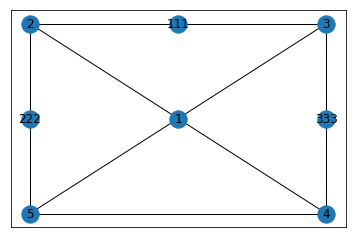

In [31]:
graph_layers_p5 = Graph_layers()
base_node_p5 = list(graph_layers_p5.get_layer(0)[0].nodes(data=True))[0]
#indexing from 0 
first_layer_G_p5 = graph_layers_p5.get_layer(0)[0].copy()

#apply p1 production
G_p5, i_node = p1(first_layer_G_p5, base_node_p5[0], graph_layers_p5.get_node_id_gen()) 

#temper the graph
rm_edge_if_exists(G_p5, 2, 3)
rm_edge_if_exists(G_p5, 2, 5)
rm_edge_if_exists(G_p5, 3, 4)
e0 = (2, G_p5.nodes[2])
e1 = (3, G_p5.nodes[3])
e2 = (5, G_p5.nodes[5])
e3 = (4, G_p5.nodes[4])
m0 = (111,{'pos' : avg_pos(e0[1]['pos'],e1[1]['pos']),'type': 'e'})
m1 = (222,{'pos' : avg_pos(e0[1]['pos'],e2[1]['pos']),'type': 'e'})
m2 = (333,{'pos' : avg_pos(e1[1]['pos'],e3[1]['pos']),'type': 'e'})
new_edges = [
     (e0[0], m1[0]), (m1[0], e2[0]),
     (e0[0], m0[0]), (m0[0], e1[0]),
     (e1[0], m2[0]), (m2[0], e3[0]),
    ]
G_p5.add_nodes_from([m0,m1,m2])
G_p5.add_edges_from(new_edges)
graph_layers_p5.add_new_layer(G_p5)
graph_layers_p5.display_i_layer(1)

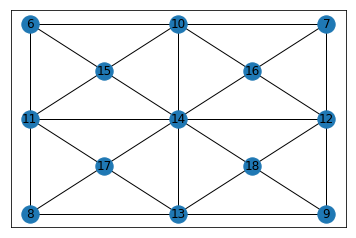

In [32]:
#apply p5 production
G_p5 = graph_layers_p5.get_layer(1)[0]
nG_p5 = p5(G_p5, 1, graph_layers_p5.get_node_id_gen())
graph_layers_p5.add_new_layer(nG_p5)
graph_layers_p5._layers[2][0].nodes(data=True)
graph_layers_p5.display_i_layer(2)

In [33]:
# p5 tests
import unittest
from collections import defaultdict

def run_test_p5():
    idc = Id_creator()
    
    # do głupiego debugowania
    def draw(g):
        pos = nx.get_node_attributes(g, 'pos')
        nx.draw_networkx(g, pos)
    
    # funkcje pomocniczne, klasa z testami poniżej
    # returns Graph, I id, list of e ids
    def make_base_graph():
        ids = [idc() for x in range(5)]
        nodes = [[i, {'type': 'e'}] for i in ids]
        i = nodes[0]
        es = nodes[1:]
        i[1]['type'] = 'i'
        
        edges = []
        pairs = [[0,1],[0,2],[1,3],[2,3]]

        for e in es:
            edges.append((i[0], e[0]))

        for a,b in pairs:
            edges.append((es[a][0], es[b][0]))
        
        i[1]['pos'] = (0,0)
        poses = [(-1, 1), (1, 1), (-1, -1), (1, -1)]
        for idx, pos in enumerate(poses):
            es[idx][1]['pos'] = pos
        
        g = nx.Graph()
        g.add_nodes_from(nodes)
        g.add_edges_from(edges)

        return g, ids[0], ids[1:]
    
    def make_basic_graph(edges=[[0,1], [0,2], [1,3]]):
        g, i, es = make_base_graph()
        for ai, bi in edges:
            a, b = es[ai], es[bi]
            add_m_between(g, a, b)
        return (g, i, es)
    
    def add_m_between(g, ia, ib):
        m = idc()
        a = g.nodes[ia]['pos']
        b = g.nodes[ib]['pos']
        g.add_nodes_from([(m, {'type': 'e', 'pos': avg_pos(a,b)})])
        g.add_edges_from([[ia,m], [m,ib]])
        g.remove_edge(ia, ib)
        return m


    class TestProduction5(unittest.TestCase):
        def is_result_ok(self, g, base_node_id):
            def where_nodes(attr, t, nodes=None):
                ns = g.nodes if nodes == None else nodes
                attrs = nx.get_node_attributes(g, attr)
                return [n for n in ns if attrs[n] == t]

            def find_nodes_between(nodes):
                # for a given set of nodes [e0, e1, e2, ...]
                # find nodes (of type 'e') that are neighbors of exactly two of these nodes
                m_scores = defaultdict(int)
                for e in nodes:
                    for neighbor in g.neighbors(e):
                        if g.nodes[neighbor]['type'] == 'e':
                            m_scores[neighbor] += 1
                ms = [k for k, v in m_scores.items() if v == 2]
                return ms

            def is_node_between(m, a, b):
                expected_pos = avg_pos(g.nodes[a]['pos'], g.nodes[b]['pos'])
                return expected_pos == g.nodes[m]['pos']
    
            Is = where_nodes('parent', base_node_id, nodes=where_nodes('type', 'I'))

            # dla każdej ćwiartki
            for I in Is:
                es = list(g.neighbors(I))
                self.assertEqual(len(es), 4)
                posc = lambda c: sum(g.nodes[n]['pos'][c] for n in es)/4
                # czy I znajduje się w średniej współrzędnych wszystkich sąsiadów
                self.assertEqual(g.nodes[I]['pos'], (posc(0), posc(1)))

            # czy pary I mają jednego/dwóch wspólnych sąsiadów
            for a, b in [[0,1], [0,2], [2,3], [1,3]]:
                I1, I2 = Is[a], Is[b]
                self.assertEqual(2, len(find_nodes_between([I1, I2])))
            for a, b in [[0,3], [1,2]]:
                I1, I2 = Is[a], Is[b]
                between = find_nodes_between([I1, I2])
                self.assertEqual(1, len(between))
                self.assertTrue(is_node_between(between[0], I1, I2))
            
            # czy I razem mają 9 e
            eses = [list(g.neighbors(I)) for I in Is]
            # flatten
            eses = [item for items in eses for item in items]
            eses = list(set(eses))
            self.assertEqual(len(eses), 9)
        

        def test_super_basic(self):
            # najprostszy test case
            g, i, es = make_basic_graph()
            p5_result = p5(g, i, idc)
            self.is_result_ok(p5_result, i)
            
            # odnajdź node po pozycji + asercja że istnieje dokładnie jeden
            def find_node(graph, pos):
                attrs = nx.get_node_attributes(graph, 'pos')
                results = [k for k, v in attrs.items() if v == pos]
                self.assertEqual(len(results), 1)
                return results[0]

            # sprawdzenie kilku nodów (górnych) i porównanie do lewej strony
            poses = nx.get_node_attributes(p5_result, 'pos')
            cord = lambda n: list(map(lambda pos: pos[n], poses.values()))
            topleft = find_node(p5_result, (min(cord(0)), max(cord(1))))
            topright = find_node(p5_result, (max(cord(0)), max(cord(1))))
            self.assertFalse(topleft in p5_result.neighbors(topright))
            
            # górny środkowy:
            topmid = find_node(p5_result, avg_pos(p5_result.nodes[topleft]['pos'], p5_result.nodes[topright]['pos']))
            self.assertTrue(topmid in p5_result.neighbors(topleft))
            self.assertTrue(topmid in p5_result.neighbors(topright))
            
            # czy istnieją odpowidniki po lewej stronie produkcji:
            
            org_topleft = find_node(g, p5_result.nodes[topleft]['pos'])
            org_topright = find_node(g, p5_result.nodes[topright]['pos'])
            org_topright = find_node(g, p5_result.nodes[topmid]['pos'])

        def test_subgraph_passes(self):
            # czy aplikuje dla podgrafu
            # dodaję ekstra wierzchołek i krawędź w kilku miejscach
            def add_to(g, n):
                some_e_id = n
                new_id = idc()
                g.add_nodes_from([(new_id, {'type': 'e', 'pos': (0, 0.5)})])
                g.add_edge(new_id, some_e_id)

            for ei in range(4):
                g, i, es = make_base_graph()

                for ai, bi in [[0,1], [0,2], [1,3]]:
                    a, b = es[ai], es[bi]
                    add_m_between(g, a, b)
                add_to(g, es[ei])
                self.is_result_ok(p5(g, i, idc), i)

            for m in range(3):
                g, i, es = make_base_graph()
                ms = []
                for ai, bi in [[0,1], [0,2], [1,3]]:
                    a, b = es[ai], es[bi]
                    ms.append(add_m_between(g, a, b))
                add_to(g, ms[m])
                self.is_result_ok(p5(g, i, idc), i)
            g, i, es = make_base_graph()
            for ai, bi in [[0,1], [0,2], [1,3]]:
                a, b = es[ai], es[bi]
                ms.append(add_m_between(g, a, b))
            # kilka ekstra wierzchołków, jeden ekstra to każdego narożnika
            for e in es:
                add_to(g, e)
            self.is_result_ok(p5(g, i, idc), i)


        def test_sides(self):
            g, i, es = make_basic_graph(edges=[[0,1], [0,2], [2,3]])
            self.is_result_ok(p5(g, i, idc), i)
            g, i, es = make_basic_graph(edges=[[0,1], [1,3], [2,3]])
            self.is_result_ok(p5(g, i, idc), i)

        def test_upsidedown(self):
            g, i, es = make_basic_graph(edges=[[0,2], [2,3], [1,3]])
            self.is_result_ok(p5(g, i, idc), i)

        # testy sprawdzające czy produkcja się nie wykona kiedy nie powinna:
        
        def test_complete(self):
            # przypadek dla grafu do lewej strony producji 6
            g, i, es = make_basic_graph(edges=[[0,1], [0,2], [2,3], [1,3]])
            with self.assertRaises(CannotExecuteProduction):
                p5(g, i, idc)
                
        def test_mislabel(self):
            # na obecnosc etykiety type: e
            g, i, es = make_base_graph()
            for ei in range(4):
                e = es[ei]
                g.nodes[e]['type'] = 'qweqweqwe'
                with self.assertRaises(CannotExecuteProduction):
                    p5(g, i, idc)

        def test_missing_e(self):
            # po usunieciu node
            g, i, es = make_base_graph()
            for ei in range(4):
                g.remove_node(es[ei])
                with self.assertRaises(CannotExecuteProduction):
                    p5(g, i, idc)


        def test_missing_m(self):
            # przypadek dobry dla produkcji 4
            g, i, es = make_basic_graph(edges=[[0,2], [2,3]])
            with self.assertRaises(CannotExecuteProduction):
                p5(g, i, idc)

        def test_missing_edges(self):
            # brak krawędzi między I a e
            g, i, es = make_basic_graph()
            g.remove_edge(i, es[0])
            with self.assertRaises(CannotExecuteProduction):
                p5(g, i, idc)
    
            # brak krawędzi między e a e
            g, i, es = make_basic_graph()
            g.remove_edge(es[2], es[3])
            with self.assertRaises(CannotExecuteProduction):
                p5(g, i, idc)
                
        def test_wrong_coords_e(self):
            g, i, es = make_basic_graph()
            g.nodes[es[0]]['pos'] = (10.0, 20.0)
            with self.assertRaises(CannotExecuteProduction):
                p5(g, i, idc)
                
        def test_wrong_coords_i(self):
            g, i, es = make_basic_graph()
            g.nodes[i]['pos'] = (10.0, 20.0)
            with self.assertRaises(CannotExecuteProduction):
                p5(g, i, idc)

    suite = unittest.defaultTestLoader.loadTestsFromTestCase(TestProduction5)
    unittest.TextTestRunner().run(suite)
run_test_p5()

...........
----------------------------------------------------------------------
Ran 11 tests in 0.018s

OK


In [34]:
def p8(top_layer, lower_layer, base_node_ids, n_id_gen):
    assert len(base_node_ids) == 4

    # step 1) select lower graph 
    lower_graphs = { G for n_id in base_node_ids for G in lower_layer if G.has_node(n_id) }
      
    assert len(lower_graphs) == 1
    lower_graph, = lower_graphs

    assert all(n_id in lower_graph.nodes for n_id in base_node_ids)
    
    # step 2) select lower i nodes and their parents
    lower_is, = group_nodes_by_attr(lower_graph, base_node_ids, 'type', str.lower).select('i')

    grouping = group_nodes_by_attr(lower_graph, lower_is, 'parent')
    assert len(grouping) == 2
    
    (top_i1, lower_i1s), (top_i2, lower_i2s) = grouping.items()
    assert len(lower_i1s) == 2
    assert len(lower_i2s) == 2
    
    # step 3) select top graph
    top_graphs = { G for n_id in (top_i1, top_i2) for G in top_layer if G.has_node(n_id) }
    assert len(top_graphs) == 1
    top_graph, = top_graphs
    
    # step 4) validate top_layer connections
    assert len(find_common_e_neighbors(top_graph, top_i1, top_i2)) >= 1
    
    # step 5) find lower e nodes candidates
    e1_candidates = find_common_e_neighbors(lower_graph, *lower_i1s)
    e2_candidates = find_common_e_neighbors(lower_graph, *lower_i2s)

    e0_candidates = find_common_group_e_neighbors(lower_graph, lower_i1s, lower_i2s, e1_candidates, e2_candidates)

    e3_candidates = find_common_group_e_neighbors(lower_graph, lower_i1s, e1_candidates) - e0_candidates
    e4_candidates = find_common_group_e_neighbors(lower_graph, lower_i2s, e2_candidates) - e0_candidates

    # step 6) solve constraints on es
    pos = lambda n_id: lower_graph.nodes[n_id]['pos']

    solutions = [
        (e0, e1, e2, e3, e4) 
        for e0 in e0_candidates 
        for e1 in e1_candidates 
        for e2 in e2_candidates 
        for e3 in e3_candidates 
        for e4 in e4_candidates
        if isapprox(pos(e1), pos(e2))
        and isapprox(pos(e3), pos(e4))
        and isapprox(pos(e1), avg_pos(pos(e0), pos(e3)))
    ]
    assert len(solutions) == 1, "can not apply production or production is ambiguous"
    (e0, e1, e2, e3, e4), = solutions

    # step 7) create graph (merge e1, e2 and e3, e4)
    new_graph = nx.contracted_nodes(lower_graph, e1, e2)
    new_graph = nx.contracted_nodes(new_graph, e3, e4)
    return new_graph, lower_graph

def apply_P8(parent_layer, child_layer, base_node_ids, n_id_gen):
    new_graph, old_graph = p8(parent_layer, child_layer, base_node_ids, n_id_gen)
    child_layer.remove(old_graph)
    child_layer.append(new_graph)

In [35]:
class P8Tests(unittest.TestCase):
    def valid_input_components(self):
        top_nodes = [
            (1,{'pos': (0,0),'type' : 'e'}),
            (2,{'pos': (-1,0),'type' : 'i'}),
            (3,{'pos': (1,0),'type' : 'i'})
        ]
        top_edges = [(1, 2), (1, 3)]
        lower_nodes = [
            (20, {'pos': (0, 1), 'type': 'e'}),
            (21, {'pos': (0, 0), 'type': 'e'}),
            (23, {'pos': (0, 0), 'type': 'e'}),
            (22, {'pos': (0,-1), 'type': 'e'}),
            (24, {'pos': (0,-1), 'type': 'e'}),

            (10, {'pos': (-0.5,0.5), 'type': 'i', 'parent': 2}),
            (12, {'pos': ( 0.5,0.5), 'type': 'i', 'parent': 3}),

            (11, {'pos': (-0.5,-0.5), 'type': 'i', 'parent': 2}),
            (13, {'pos': ( 0.5,-0.5), 'type': 'i', 'parent': 3}),
        ]
        lower_edges = [
            (20,21), (20,23), 
            (21,22), (23,24),
            (10,20), (10,21),
            (12,20), (12,23),
            (11,21), (11,22),
            (13,23), (13,24),
        ]
        return top_nodes, top_edges, lower_nodes, lower_edges
        
    def valid_output_components(self):
        top_nodes = [
            (1,{'pos': (0,0),'type' : 'e'}),
            (2,{'pos': (-1,0),'type' : 'i'}),
            (3,{'pos': (1,0),'type' : 'i'})
        ]
        top_edges = [(1, 2), (1, 3)]
        lower_nodes = [
            (20, {'pos': (0, 1), 'type': 'e'}),
            (21, {'pos': (0, 0), 'type': 'e'}),
            (22, {'pos': (0,-1), 'type': 'e'}),

            (10, {'pos': (-0.5,0.5), 'type': 'i', 'parent': 2}),
            (12, {'pos': ( 0.5,0.5), 'type': 'i', 'parent': 3}),

            (11, {'pos': (-0.5,-0.5), 'type': 'i', 'parent': 2}),
            (13, {'pos': ( 0.5,-0.5), 'type': 'i', 'parent': 3}),
        ]
        lower_edges = [
            (20,21), (20,21), 
            (21,22),
            (10,20), (10,21),
            (12,20), (12,21),
            (11,21), (11,22),
            (13,21), (13,22),
        ]
        return top_nodes, top_edges, lower_nodes, lower_edges   
        
    def create_graph(self, top_nodes, top_edges, lower_nodes, lower_edges):
        graph = Graph_layers()
        top_graph = nx.Graph()
        top_graph.add_nodes_from(top_nodes)
        top_graph.add_edges_from(top_edges)
        graph.add_new_layer(top_graph)
        
        lower_graph = nx.Graph()
        lower_graph.add_nodes_from(lower_nodes)
        lower_graph.add_edges_from(lower_edges)
        graph.add_new_layer(lower_graph)

        return graph
    
    def test_applying_production_to_minimum_valid_graph(self):
        top_nodes, top_edges, lower_nodes, lower_edges = self.valid_input_components()
        graph = self.create_graph(top_nodes, top_edges, lower_nodes, lower_edges)
    
        apply_P8(graph.get_layer(1), graph.get_layer(2), [10,11,12,13], graph.get_node_id_gen())
    
        valid_output = self.create_graph(*self.valid_output_components())
        self.assertTrue(nx.is_isomorphic(graph.get_layer(2)[0], valid_output.get_layer(2)[0], node_match=lambda n1,n2: n1['type'] == n2['type'] and n1.get('parent', -2) == n2.get('parent', -2)))
    
    def test_should_fail_without_node(self):
        top_nodes, top_edges, lower_nodes, lower_edges = self.valid_input_components()
        for node in lower_nodes:
            lower_nodes_missing = list(lower_nodes)
            lower_nodes_missing.remove(node)
            n_id, _ = node
            lower_edges_missing = [edge for edge in lower_edges if n_id not in edge]

            graph = self.create_graph(top_nodes, top_edges, lower_nodes_missing, lower_edges_missing)
            with self.assertRaises(AssertionError):
                apply_P8(graph.get_layer(1), graph.get_layer(2), [10,11,12,13], graph.get_node_id_gen())
    
    def test_should_fail_without_edge(self):
        top_nodes, top_edges, lower_nodes, lower_edges = self.valid_input_components()
        for edge in lower_edges:
            lower_edges_missing = list(lower_edges)
            lower_edges_missing.remove(edge)
        
            graph = self.create_graph(top_nodes, top_edges, lower_nodes, lower_edges_missing)
            with self.assertRaises(AssertionError):
                apply_P8(graph.get_layer(1), graph.get_layer(2), [10,11,12,13], graph.get_node_id_gen())
    
    def test_should_fail_with_invalid_lavel(self):
        top_nodes, top_edges, lower_nodes, lower_edges = self.valid_input_components()
        
        for i, (n_id, meta) in enumerate(lower_nodes):
            lower_nodes_invalid = deepcopy(lower_nodes)
            del lower_nodes_invalid[i]
            meta['type'] = 'i' if meta['type'] == 'e' else 'e'
            lower_nodes_invalid.append((n_id, meta))

            graph = self.create_graph(top_nodes, top_edges, lower_nodes_invalid, lower_edges)
            with self.assertRaises(AssertionError):
                apply_P8(graph.get_layer(1), graph.get_layer(2), [10,11,12,13], graph.get_node_id_gen())           
    
    def test_should_fail_with_invalid_label(self):
        top_nodes, top_edges, lower_nodes, lower_edges = self.valid_input_components()
        
        for i, (n_id, meta) in enumerate(lower_nodes):
            lower_nodes_invalid = deepcopy(lower_nodes)
            del lower_nodes_invalid[i]
            meta['type'] = 'i' if meta['type'] == 'e' else 'e'
            lower_nodes_invalid.append((n_id, meta))

            graph = self.create_graph(top_nodes, top_edges, lower_nodes_invalid, lower_edges)
            with self.assertRaises(AssertionError):
                apply_P8(graph.get_layer(1), graph.get_layer(2), [10,11,12,13], graph.get_node_id_gen())   
        
    def test_should_fail_with_invalid_coords(self):
        top_nodes, top_edges, lower_nodes, lower_edges = self.valid_input_components()
        lower_nodes.remove((20, {'pos': (0, 1), 'type': 'e'}))
        lower_nodes.append((20, {'pos': (0, 100), 'type': 'e'}))
        
        graph = self.create_graph(top_nodes, top_edges, lower_nodes, lower_edges)
        with self.assertRaises(AssertionError):
            apply_P8(graph.get_layer(1), graph.get_layer(2), [10,11,12,13], graph.get_node_id_gen())  
    
    def test_should_work_as_subgraph(self):
        top_nodes, top_edges, lower_nodes, lower_edges = self.valid_input_components()
        lower_nodes += [
            (14, {'pos': (-0.5,0.5), 'type': 'i', 'parent': 2}),
            (15, {'pos': (-0.5,0.5), 'type': 'i', 'parent': 3}),
        ]
        lower_edges += [(20, 15), (20, 14), (15, 13), (24, 15)]
        graph = self.create_graph(top_nodes, top_edges, lower_nodes, lower_edges)
        apply_P8(graph.get_layer(1), graph.get_layer(2), [10,11,12,13], graph.get_node_id_gen())

In [36]:
#  P(6)
#     e0 - m0 - e1
#      | \    / |
#     m1   I0   m2
#      | /   \  |
#     e2 - m3 - e3
#
#          |
#         \/
#
#     e0 - - - m0 - - - e1
#     | \    / | \    / |
#     |  I1    |  I2    |
#     | /   \  | /   \  |
#    m1 - - - n0 - - - m2
#     | \    / | \    / |
#     |  I3    |  I4    |
#     | /   \  | /   \  |
#    e2 - - - m3 - - - e3

def p6(G, base_node_id, n_id_gen):
    assert(G.nodes[base_node_id]['type'].lower() == 'i')
    nG = nx.Graph()
    es = list(G.neighbors(base_node_id))

    # check if I has 4 neighbours
    if len(es) != 4:
        raise CannotExecuteProduction

    # assign e
    e0, e1, e2, e3 = None, None, None, None
    baseX, baseY = G.nodes[base_node_id]['pos']
    for ex in es:
        x,y = G.nodes[ex]['pos']
        if x<baseX:
            if y<baseY:
                e2= (ex,G.nodes[ex])
            if y>baseY:
                e0= (ex,G.nodes[ex])
        else:
            if y<baseY:
                e3= (ex,G.nodes[ex])
            if y>baseY:
                e1= (ex,G.nodes[ex])

    e0_neigh = list(G.neighbors(e0[0]))
    e1_neigh = list(G.neighbors(e1[0]))
    e2_neigh = list(G.neighbors(e2[0]))
    e3_neigh = list(G.neighbors(e3[0]))

    # assign m & check m (x,y)
    m0, m1, m2, m3 = None, None, None, None
    e0X, e0Y = e0[1]['pos']
    e1X, e1Y = e1[1]['pos']
    e2X, e2Y = e2[1]['pos']
    e3X, e3Y = e3[1]['pos']
    for node_x in e0_neigh:
        x,y = G.nodes[node_x]['pos']
        if x==(e0X+e1X)/2 and y==(e0Y+e1Y)/2:
            m0 = (node_x,G.nodes[node_x])
        if x==(e0X+e2X)/2 and y==(e0Y+e2Y)/2:
            m1 = (node_x,G.nodes[node_x])
    for node_x in e1_neigh:
        x,y = G.nodes[node_x]['pos']
        if x==(e1X+e3X)/2 and y==(e1Y+e3Y)/2:
            m2 = (node_x,G.nodes[node_x])
    for node_x in e2_neigh:
        x,y = G.nodes[node_x]['pos']
        if x==(e2X+e3X)/2 and y==(e2Y+e3Y)/2:
            m3 = (node_x,G.nodes[node_x])
    if m0 is None or m1 is None or m2 is None or m3 is None:
        raise CannotExecuteProduction

    # check if each m has 2 neighbours
    m0_neigh = list(G.neighbors(m0[0]))
    m1_neigh = list(G.neighbors(m1[0]))
    m2_neigh = list(G.neighbors(m2[0]))
    m3_neigh = list(G.neighbors(m3[0]))
    if (len(m0_neigh) != 2 or
        len(m1_neigh) != 2 or
        len(m2_neigh) != 2 or
        len(m3_neigh) != 2):
        raise CannotExecuteProduction

    # check I0 edges
    if not(G.has_edge(e0[0],base_node_id) and
            G.has_edge(e1[0],base_node_id) and
            G.has_edge(e2[0],base_node_id) and
            G.has_edge(e3[0],base_node_id)
            ):
        raise CannotExecuteProduction

    # check each e and m edges
    if not(G.has_edge(e0[0], m0[0]) and
            G.has_edge(e0[0], m1[0]) and
            G.has_edge(e1[0], m0[0]) and
            G.has_edge(e1[0], m2[0]) and
            G.has_edge(e2[0], m1[0]) and
            G.has_edge(e2[0], m3[0]) and
            G.has_edge(e3[0], m2[0]) and
            G.has_edge(e3[0], m3[0])
            ):
        raise CannotExecuteProduction

    #prepare all new vertices according to map above
    e0 = (n_id_gen(),{'pos': e0[1]['pos'],'type' : e0[1]['type']})
    e1 = (n_id_gen(),{'pos': e1[1]['pos'],'type' : e1[1]['type']})
    e2 = (n_id_gen(),{'pos': e2[1]['pos'],'type' : e2[1]['type']})
    e3 = (n_id_gen(),{'pos': e3[1]['pos'],'type' : e3[1]['type']})

    m0 = (n_id_gen(),{'pos' : m0[1]['pos'],'type': m0[1]['type']})
    m1 = (n_id_gen(),{'pos' : m1[1]['pos'],'type': m1[1]['type']})
    m2 = (n_id_gen(),{'pos' : m2[1]['pos'],'type': m2[1]['type']})
    m3 = (n_id_gen(),{'pos' : m3[1]['pos'],'type': m3[1]['type']})

    n0 = (n_id_gen(),{'pos' : avg_pos(e1[1]['pos'],e2[1]['pos']),'type':'e'})

    I1 = (n_id_gen(),{'pos' : avg_pos(e0[1]['pos'],n0[1]['pos']),'type':'I','parent':base_node_id})
    I2 = (n_id_gen(),{'pos' : avg_pos(e1[1]['pos'],n0[1]['pos']),'type':'I','parent':base_node_id})
    I3 = (n_id_gen(),{'pos' : avg_pos(e2[1]['pos'],n0[1]['pos']),'type':'I','parent':base_node_id})
    I4 = (n_id_gen(),{'pos' : avg_pos(e3[1]['pos'],n0[1]['pos']),'type':'I','parent':base_node_id})

    # add all new edges
    new_edges = [
        (e0[0],m0[0]),(m0[0],e1[0]),
        (e0[0],I1[0]),(m0[0],I1[0]), (m0[0],I2[0]),(e1[0],I2[0]),
        (e0[0],m1[0]),(m0[0],n0[0]),(e1[0],m2[0]),
        (m1[0],I1[0]),(n0[0],I1[0]), (n0[0],I2[0]),(m2[0],I2[0]),
        (m1[0],n0[0]),(n0[0],m2[0]),
        (m1[0],I3[0]),(n0[0],I3[0]), (n0[0],I4[0]),(m2[0],I4[0]),
        (m1[0],e2[0]),(n0[0],m3[0]),(m2[0],e3[0]),
        (e2[0],I3[0]),(m3[0],I3[0]), (m3[0],I4[0]),(e3[0],I4[0]),
        (e2[0],m3[0]),(m3[0],e3[0]),
    ]
    nG.add_nodes_from([e0,e1,e2,e3,m0,m1,m2,n0,m3,I1,I2,I3,I4])
    nG.add_edges_from(new_edges)
    return nG

p6 simple graph


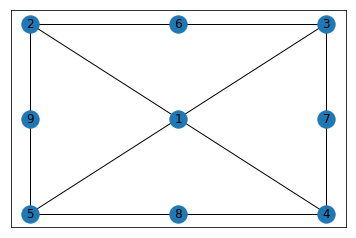

Applying p6 production on correct graph
Base layer


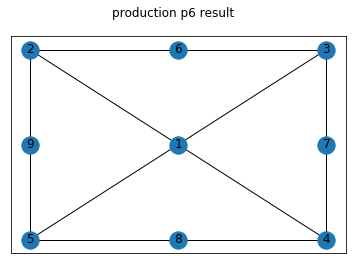

Added layer


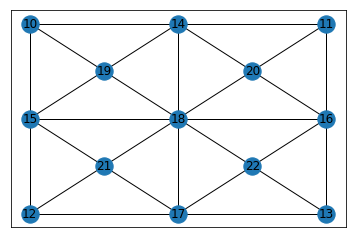


p6 on subgraph
Trying to use p6 on graph with missing vertex


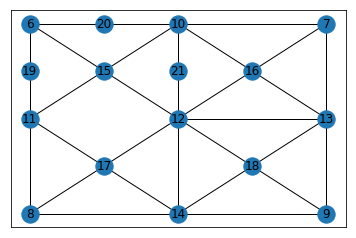

CannotExecuteProduction exception caught
Trying to use p6 on graph with missing edge


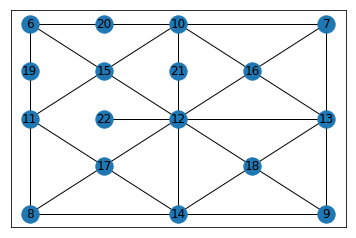

CannotExecuteProduction exception caught


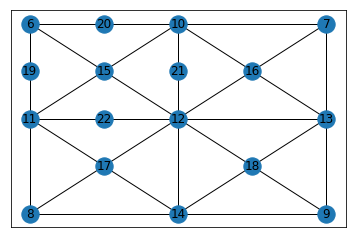

Applying p6 production on correct graph
Base layer


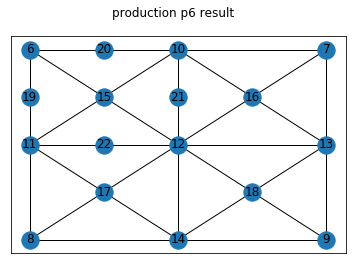

Added layer


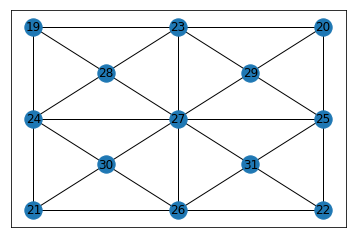

In [37]:
def p6_tests():
    
    def print_res(graph_layers,prod_f, prod,start_layer):
        fig1 = plt.figure(1)
        graph_layers.display_i_layer(start_layer)
        fig1.suptitle(f'base {prod} graph')
        plt.show()
        print(f'Applying {prod} production on correct graph')
        graph_layers.add_new_layer(prod_f())
        fig2 = plt.figure(2)
        fig2.suptitle(f'production {prod} result')
        print('Base layer')
        graph_layers.display_i_layer(start_layer)
        plt.show()
        print('Added layer')
        graph_layers.display_i_layer(start_layer+1)
        plt.show()
        print()
    
    def prepare_graph(f=None):
        graph_layers = Graph_layers()
        base_node = list(graph_layers.get_layer(0)[0].nodes(data=True))[0]
        first_layer_G = graph_layers.get_layer(0)[0].copy()
        if f:
            G, i_node = f(first_layer_G, base_node[0], graph_layers.get_node_id_gen())
            graph_layers.add_new_layer(G)
        else:
            G, i_node = p1(first_layer_G, base_node[0], graph_layers.get_node_id_gen()) 
            graph_layers.add_new_layer(G)
            G = graph_layers.get_layer(1)[0]
            G = p2(G, 1, graph_layers.get_node_id_gen())
            graph_layers.add_new_layer(G)
            graph_layers._layers[2][0].nodes(data=True)
        return graph_layers,G,i_node
        
        
    def pX1(G, base_node_id, n_id_gen, side_len=2, max_random_offset = 0):
        assert(G.nodes[base_node_id]['type'].lower() == 'e' )
        assert(len(G.nodes)==1)
        all_new_nodes = []
        all_new_edges = []
        base_pos = G.nodes[base_node_id]['pos']
        x_offset = ((np.random.random()-0.5) * max_random_offset * 2)
        y_offset = ((np.random.random()-0.5) * max_random_offset * 2)
        i_node_x, i_node_y = base_pos[0], base_pos[1]
        i_node = (n_id_gen(), {'pos': (i_node_x+x_offset, i_node_y-y_offset), 'type': 'I','parent': -1})
        all_new_nodes.append(i_node)

        half_side_len = side_len/2
        e_nodes = [
            (n_id_gen(), {'pos': (i_node_x - half_side_len, i_node_y + half_side_len),'type': 'e'}),
            (n_id_gen(), {'pos': (i_node_x + half_side_len, i_node_y + half_side_len),'type': 'e'}),
            (n_id_gen(), {'pos': (i_node_x + half_side_len, i_node_y - half_side_len),'type': 'e'}),
            (n_id_gen(), {'pos': (i_node_x - half_side_len, i_node_y - half_side_len),'type': 'e'}),
            (n_id_gen(), {'pos': (i_node_x, i_node_y + half_side_len),'type': 'e'}),
            (n_id_gen(), {'pos': (i_node_x + half_side_len, i_node_y),'type': 'e'}),
            (n_id_gen(), {'pos': (i_node_x, i_node_y - half_side_len),'type': 'e'}),
            (n_id_gen(), {'pos': (i_node_x - half_side_len, i_node_y),'type': 'e'})
        ]
        for i in range(len(e_nodes)):
            if i < 4:
                all_new_edges.extend([(i_node[0],e_nodes[i][0]), (e_nodes[i][0], e_nodes[i+4][0])])
                if i > 0:
                    all_new_edges.extend([(e_nodes[i][0], e_nodes[i+3][0])])
        
        all_new_edges.extend([(e_nodes[0][0], e_nodes[len(e_nodes)-1][0])])
        all_new_nodes.extend(e_nodes)
        nG = nx.Graph()
        nG.add_nodes_from(all_new_nodes)
        nG.add_edges_from(all_new_edges)
        return nG, i_node
    
    #test 1
    print('p6 simple graph')
    graph_layers, G, i_node = prepare_graph(pX1)
    print_res(graph_layers,lambda :p6(G, i_node[0], graph_layers.get_node_id_gen()),'p6',1)
    
    #test 2
    print('p6 on subgraph')
    graph_layers, G, i_node = prepare_graph()
    rm_edge_if_exists(G, 6, 11)
    rm_edge_if_exists(G, 6, 10)
    rm_edge_if_exists(G, 10, 12)
    rm_edge_if_exists(G, 12, 11)
    n6 = list(G.nodes(data=True))[0]
    n10 = list(G.nodes(data=True))[4]
    n11 = list(G.nodes(data=True))[5]
    n12 = list(G.nodes(data=True))[6]
    n19 = (19, {'pos' : avg_pos(n6[1]['pos'],n11[1]['pos']),'type':'e'})
    n20 = (20, {'pos' : avg_pos(n6[1]['pos'],n10[1]['pos']),'type':'e'})
    n21 = (21, {'pos' : avg_pos(n10[1]['pos'],n12[1]['pos']),'type':'e'})
    n22 = (22, {'pos' : avg_pos(n12[1]['pos'],n11[1]['pos']),'type':'e'})
    G.add_nodes_from([n19, n20, n21])
    G.add_edges_from([(n6[0], n19[0]), (n19[0], n11[0]), (n20[0], n6[0]), (n10[0], n20[0]),
                     (n10[0], n21[0]), (n21[0], n12[0])])
    print("Trying to use p6 on graph with missing vertex")
    graph_layers.display_i_layer(2)
    plt.show()
    try:
        p6(G, 15, graph_layers.get_node_id_gen())
    except CannotExecuteProduction:
        print("CannotExecuteProduction exception caught")
    G.add_nodes_from([n22])
    G.add_edges_from([(n12[0], n22[0])])
    print("Trying to use p6 on graph with missing edge")
    graph_layers.display_i_layer(2)
    plt.show()
    try:
        p6(G, 15, graph_layers.get_node_id_gen())
    except CannotExecuteProduction:
        print("CannotExecuteProduction exception caught")
    G.add_edges_from([(n22[0], n11[0])])
    
    print_res(graph_layers,lambda :p6(G, 15, graph_layers.get_node_id_gen()),'p6',2)
p6_tests()

In [38]:
#
#
#
#      I1  - e1 - I3
#        \  /   \ /
#         e2    e2
#        / \   / \
#     I2  - e3 - I4
#
#          |
#         \/
#
#      I1  - e1 - I3
#        \   |   /
#            e2
#        /   |   \
#     I2  - e3 - I4

def p9(top_layer, lower_layer, base_node_ids, n_ids_gen):
    assert_is_true(len(base_node_ids) == 3)
    assert_is_true(len(n_ids_gen) == 4)

    # Get top graph from layer
    top_graphs = list(set([[G for G in top_layer if G.has_node(n_id)][0] for n_id in base_node_ids]))
    assert_is_true(len(top_graphs) == 1)
    g_top = top_graphs[0]

    top_nodes = [(n_id, g_top.nodes[n_id]) for n_id in base_node_ids]
    t_nodes_e = [n for n in top_nodes if n[1]['type'].lower() == 'e']
    t_nodes_i = [n for n in top_nodes if n[1]['type'].lower() == 'i']
    assert_is_true(len(t_nodes_e) == 1)
    assert_is_true(len(t_nodes_i) == 2)

    t_node_e = t_nodes_e[0]
    t_node_i_0 = t_nodes_i[0]
    t_node_i_1 = t_nodes_i[1]
    assert_is_true(g_top.has_edge(t_node_e[0], t_node_i_0[0]) and g_top.has_edge(t_node_e[0], t_node_i_1[0]))


    # Get bottom graph from layer
    bot_graph_lists = [[G for G in lower_layer if G.has_node(n_id)] for n_id in n_ids_gen]
    for bl in bot_graph_lists:
        assert_is_true(len(bl) > 0)
    bot_graphs = list(set([b[0] for b in bot_graph_lists]))
    assert_is_true(len(bot_graphs) == 1)
    g_bot = bot_graphs[0]

    bot_nodes = [(n_id, g_bot.nodes[n_id]) for n_id in n_ids_gen]
    b_nodes_i = [n for n in bot_nodes if n[1]['type'].lower() == 'i']
    assert_is_true(len(b_nodes_i) == 4)


    # Get bottom i nodes - for left and right top i
    b_nodes_i_l = [n for n in bot_nodes if n[1]['parent'] == t_node_i_0[0]]
    b_nodes_i_p = [n for n in bot_nodes if n[1]['parent'] == t_node_i_1[0]]
    assert_is_true(len(b_nodes_i_l) == 2)
    assert_is_true(len(b_nodes_i_p) == 2)

    # Get bottom e nodes
    b_nodes_i_l_0_neigh = [(n_id, g_bot.nodes[n_id]) for n_id in g_bot.neighbors(b_nodes_i_l[0][0])
                            if g_bot.nodes[n_id]['type'].lower() == 'e']
    b_nodes_i_l_1_neigh = [(n_id, g_bot.nodes[n_id]) for n_id in g_bot.neighbors(b_nodes_i_l[1][0])
                            if g_bot.nodes[n_id]['type'].lower() == 'e']
    b_nodes_i_p_0_neigh = [(n_id, g_bot.nodes[n_id]) for n_id in g_bot.neighbors(b_nodes_i_p[0][0])
                            if g_bot.nodes[n_id]['type'].lower() == 'e']
    b_nodes_i_p_1_neigh = [(n_id, g_bot.nodes[n_id]) for n_id in g_bot.neighbors(b_nodes_i_p[1][0])
                            if g_bot.nodes[n_id]['type'].lower() == 'e']
    assert_is_true(len(b_nodes_i_l_0_neigh) > 0)
    assert_is_true(len(b_nodes_i_l_1_neigh) > 0)
    assert_is_true(len(b_nodes_i_p_0_neigh) > 0)
    assert_is_true(len(b_nodes_i_p_1_neigh) > 0)

    # Find candidate e nodes
    b_nodes_e_l = list({n[0]: n for n in b_nodes_i_l_0_neigh + b_nodes_i_l_1_neigh}.values())
    b_nodes_e_p = list({n[0]: n for n in b_nodes_i_p_0_neigh + b_nodes_i_p_1_neigh}.values())

    b_nodes_e_lp = [(n0, n1) for n0 in b_nodes_e_l for n1 in b_nodes_e_p
                        if n0[0] != n1[0]
                        and math.isclose(n0[1]['pos'][0], n1[1]['pos'][0])
                        and math.isclose(n0[1]['pos'][1], n1[1]['pos'][1])
                        and not g_bot.has_edge(n0[0], n1[0])]
    b_nodes_e_o = list({n[0]: n for n in b_nodes_e_l + b_nodes_e_p}.values())

    # Find candidate nodes to merge
    to_merge = []
    for e_t in b_nodes_e_o:
        for e_b in b_nodes_e_o:
            e_t_id = e_t[0]
            e_b_id = e_b[0]
            if e_t_id == e_b_id:
                continue
            for e_m0, e_m1 in b_nodes_e_lp:
                e_m0_id = e_m0[0]
                e_m1_id = e_m1[0]

                if e_t_id == e_m0_id or e_b_id == e_m0_id\
                or e_t_id == e_m1_id or e_b_id == e_m1_id:
                    continue

                if not g_bot.has_edge(e_t_id, e_m0_id)\
                or not g_bot.has_edge(e_t_id, e_m1_id)\
                or not g_bot.has_edge(e_b_id, e_m0_id)\
                or not g_bot.has_edge(e_b_id, e_m1_id):
                    continue

                x = (e_t[1]['pos'][0] + e_b[1]['pos'][0]) / 2
                y = (e_t[1]['pos'][1] + e_b[1]['pos'][1]) / 2
                if not math.isclose(e_m0[1]['pos'][0], x)\
                or not math.isclose(e_m0[1]['pos'][1], y):
                    continue

                i_l_0_ids = [n_id for n_id, _ in b_nodes_i_l if g_bot.has_edge(n_id, e_t_id) and g_bot.has_edge(n_id, e_m0_id)]
                i_l_1_ids = [n_id for n_id, _ in b_nodes_i_l if g_bot.has_edge(n_id, e_b_id) and g_bot.has_edge(n_id, e_m0_id)]
                i_p_0_ids = [n_id for n_id, _ in b_nodes_i_p if g_bot.has_edge(n_id, e_t_id) and g_bot.has_edge(n_id, e_m1_id)]
                i_p_1_ids = [n_id for n_id, _ in b_nodes_i_p if g_bot.has_edge(n_id, e_b_id) and g_bot.has_edge(n_id, e_m1_id)]

                if len(i_l_0_ids) == 0\
                or len(i_l_1_ids) == 0\
                or len(i_p_0_ids) == 0\
                or len(i_p_1_ids) == 0:
                    continue
                to_merge.append((e_m0_id, e_m1_id))

    to_merge = list(set(to_merge))
    assert_is_true(len(to_merge) > 0)
    u, v = to_merge[0]
    new_graph = nx.contracted_nodes(g_bot, u, v)
    return new_graph, g_bot

def assert_is_true(predicate):
    if not predicate:
        raise CannotExecuteProduction

def apply_p9(parent_layer, child_layer, base_node_ids, n_ids_gen):
    new_graph, old_graph = p9(parent_layer, child_layer, base_node_ids, n_ids_gen)
    child_layer.remove(old_graph)
    child_layer.append(new_graph)

In [39]:
class TestNotebookP9(unittest.TestCase):

    def create_valid_output_layer(self):
        graph_layers = Graph_layers()
        id_gen = graph_layers.get_node_id_gen()
        l2 = nx.Graph()
        l2_edges = []
        l2_nodes = []
        center_x, center_y, offset, = 2, 2, -1
        upper_i_left = (id_gen.get_id(), {'pos': (center_x + offset, center_y + 1),'type': 'I', 'parent': 2})
        lower_i_left = (id_gen.get_id(), {'pos': (center_x + offset, center_y - 1),'type': 'I', 'parent': 2})
        offset = -offset
        upper_i_right = (id_gen.get_id(), {'pos': (center_x + offset, center_y + 1),'type': 'I', 'parent': 3})
        lower_i_right = (id_gen.get_id(), {'pos': (center_x + offset, center_y - 1),'type': 'I', 'parent': 3})

        l2_nodes.extend([upper_i_right, upper_i_left, lower_i_left, lower_i_right])

        upper_e = (id_gen.get_id(), {'pos': (center_x, center_y + 1.5),'type': 'e'})
        mid_e = (id_gen.get_id(), {'pos': (center_x, center_y),'type': 'e'})
        lower_e = (id_gen.get_id(), {'pos': (center_x, center_y - 1.5),'type': 'e'})

        l2_nodes.extend([upper_e, mid_e, lower_e])
        l2_edges.extend([(upper_e[0], mid_e[0]), (lower_e[0], mid_e[0]),
                         (lower_e[0], lower_i_left[0]),
                         (lower_e[0], lower_i_right[0]),
                         (lower_i_left[0], mid_e[0]),
                         (lower_i_right[0], mid_e[0]),
                         (upper_i_left[0], mid_e[0]),
                         (upper_i_right[0], mid_e[0]),
                         (upper_i_right[0], upper_e[0]),
                         (upper_i_left[0], upper_e[0])])

        l2.add_nodes_from(l2_nodes)
        l2.add_edges_from(l2_edges)
        graph_layers.add_new_layer(l2)
#         graph_layers.display_i_layer(1)
        return graph_layers.get_layer(1)[0]


    def create_leaf_edges(self, parent, id_gen, offset, tiny_offset):
        center_x, center_y = 2, 2
        l2 = nx.Graph()
        l2_edges = []
        l2_nodes = []
        upper_i_left = (id_gen.get_id(), {'pos': (center_x + offset, center_y + 1),'type': 'I', 'parent': parent[0][0]})
        lower_i_left = (id_gen.get_id(), {'pos': (center_x + offset, center_y - 1),'type': 'I', 'parent': parent[0][0]})
        upper_i_right = (id_gen.get_id(), {'pos': (center_x - offset, center_y + 1),'type': 'I', 'parent': parent[1][0]})
        lower_i_right = (id_gen.get_id(), {'pos': (center_x - offset, center_y - 1),'type': 'I', 'parent': parent[1][0]})
        l2_nodes.extend([upper_i_left, lower_i_left, upper_i_right, lower_i_right])

        upper_e = (id_gen.get_id(), {'pos': (center_x + tiny_offset, center_y + 1.5),'type': 'e'})
        mid_e_left = (id_gen.get_id(), {'pos': (center_x + tiny_offset, center_y),'type': 'e'})
        mid_e_right = (id_gen.get_id(), {'pos': (center_x + tiny_offset, center_y),'type': 'e'})
        lower_e = (id_gen.get_id(), {'pos': (center_x + tiny_offset, center_y - 1.5),'type': 'e'})

        l2_nodes.extend([upper_e, mid_e_left, mid_e_right, lower_e])
        l2_edges.extend([(upper_e[0], mid_e_left[0]), (upper_e[0], mid_e_right[0]),
                         (lower_e[0], mid_e_left[0]), (lower_e[0], mid_e_right[0]),
                         (upper_i_left[0], upper_e[0]), (upper_i_left[0], mid_e_left[0]),
                         (lower_i_left[0], lower_e[0]), (lower_i_left[0], mid_e_left[0]),
                         (upper_i_right[0], upper_e[0]), (upper_i_right[0], mid_e_right[0]),
                         (lower_i_right[0], lower_e[0]), (lower_i_right[0], mid_e_right[0]),
                        ])

        l2.add_nodes_from(l2_nodes)
        l2.add_edges_from(l2_edges)

        return l2, [upper_i_left[0], lower_i_left[0], upper_i_right[0], lower_i_right[0]]

    def create_valid_input_net(self):
        graph_layers = Graph_layers()
        side_len = 2
        parent_node_x, parent_node_y = 1, 1
        id_gen = graph_layers.get_node_id_gen()
        parent_node = (id_gen.get_id(), {'pos': (parent_node_x, parent_node_y), 'type': 'E','parent': -1})

        half_side_len = side_len/2
        i_nodes = [
            (id_gen.get_id(), {'pos': (parent_node_x + half_side_len, parent_node_y - half_side_len),'type': 'I', 'parent': parent_node[0]}),
            (id_gen.get_id(), {'pos': (parent_node_x - half_side_len, parent_node_y - half_side_len),'type': 'I', 'parent': parent_node[0]})
        ]
        l1_edges = []
        for i_node in i_nodes:
             l1_edges.extend([(i_node[0],parent_node[0])])

        l1 = nx.Graph()
        l1.add_nodes_from([parent_node])
        l1.add_nodes_from(i_nodes)
        l1.add_edges_from(l1_edges)
        graph_layers.add_new_layer(l1)

        center_x, center_y, offset, tiny_offset = 2, 2, -1, -0.05
        left_graph, output_ids = self.create_leaf_edges(i_nodes, id_gen, offset, tiny_offset)
        graph_layers.add_new_layer(left_graph)
        offset = -offset

#         graph_layers.display_i_layer(2)

        return graph_layers, [parent_node[0], i_nodes[0][0], i_nodes[1][0]], output_ids

    def test_p9_correct(self):
        initial, intermediate_i_node_ids, output_ids = self.create_valid_input_net()
        output = p9(initial.get_layer(1), initial.get_layer(2), intermediate_i_node_ids, output_ids)
        assert nx.is_isomorphic(self.create_valid_output_layer(), output[0], node_match=lambda n1,n2: n1['type'] == n2['type'] and n1.get('parent', -2) == n2.get('parent', -2))


    def test_p9_remove_random_edge(self):
        layers, intermediate_i_node_ids, output_ids = self.create_valid_input_net()
        lastLayer = layers.get_layer(2)[0]
        edges = list(lastLayer.edges)

        # random edge choice
        chosen_edge = random.choice(edges)
        print(chosen_edge)
        lastLayer.remove_edge(chosen_edge[0], chosen_edge[1])

        with self.assertRaises(CannotExecuteProduction):
            p9(layers.get_layer(1), [lastLayer], intermediate_i_node_ids, output_ids)


    def test_p9_remove_random_node(self):
        layers, intermediate_i_node_ids, output_ids = self.create_valid_input_net()
        lastLayer = layers.get_layer(2)[0]
        nodes = list(lastLayer.nodes)

        node_to_remove = random.choice(nodes)
        print(node_to_remove)
        # random node choice
        lastLayer.remove_node(node_to_remove)

        with self.assertRaises(CannotExecuteProduction):
            p9(layers.get_layer(1), [lastLayer], intermediate_i_node_ids, output_ids)

    def test_p9_incorect_coordinates(self):
        layers, intermediate_i_node_ids, output_ids = self.create_valid_input_net()
        lastLayer = layers.get_layer(2)[0]
        lastLayer.nodes[10]['pos'] = (0, 0)

        with self.assertRaises(CannotExecuteProduction):
            p9(layers.get_layer(1), [lastLayer], intermediate_i_node_ids, output_ids)

    def test_p9_incorect_label(self):
        layers, intermediate_i_node_ids, output_ids = self.create_valid_input_net()
        layers.get_layer(2)[0].nodes[5]['type'] = 'e'
        lastLayer = layers.get_layer(2)[0]

        with self.assertRaises(CannotExecuteProduction):
            p9(layers.get_layer(1), [lastLayer], intermediate_i_node_ids, output_ids)

unittest.main(argv=[''], verbosity=2, exit=False)

test_applying_production_to_minimum_valid_graph (__main__.P8Tests) ... ok
test_should_fail_with_invalid_coords (__main__.P8Tests) ... ok
test_should_fail_with_invalid_label (__main__.P8Tests) ... ok
test_should_fail_with_invalid_lavel (__main__.P8Tests) ... ok
test_should_fail_without_edge (__main__.P8Tests) ... ok
test_should_fail_without_node (__main__.P8Tests) ... ok
test_should_work_as_subgraph (__main__.P8Tests) ... ok
test_p7_correct (__main__.TestNotebook) ... ok
test_p7_remove_parent_attribute (__main__.TestNotebook) ... ok
test_p7_remove_random_edge (__main__.TestNotebook) ... ok
test_p7_remove_random_node (__main__.TestNotebook) ... ok
test_p9_correct (__main__.TestNotebookP9) ... ok
test_p9_incorect_coordinates (__main__.TestNotebookP9) ... ok
test_p9_incorect_label (__main__.TestNotebookP9) ... ok
test_p9_remove_random_edge (__main__.TestNotebookP9) ... ok
test_p9_remove_random_node (__main__.TestNotebookP9) ... 

(8, 9)
8


ok

----------------------------------------------------------------------
Ran 16 tests in 0.028s

OK


In [40]:
def p10(top_layer, base_node_id, n_id_gen):
    Gs = { G for G in top_layer if G.has_node(base_node_id) }
    assert len(Gs) == 1
    G, = Gs

    assert G.nodes[base_node_id]['type'].lower() == 'i'
    nodes_to_copy, = group_nodes_by_attr(G, list(G.neighbors(base_node_id)), 'type', str.lower).select('e')
    assert(len(nodes_to_copy)==4)
    
    old_to_new = { old_id: n_id_gen() for old_id in nodes_to_copy }
    I = n_id_gen()
    new_nodes = [
        (new_id, {'pos': G.nodes[old_id]['pos'], 'type': 'e'})
        for old_id, new_id in old_to_new.items()
    ] + [(I, {'pos': G.nodes[base_node_id]['pos'], 'type': 'i', 'parent': base_node_id})]
    new_edges = [(new_source_id, old_to_new[old_target_id]) 
        for old_source_id, new_source_id in old_to_new.items() 
        for old_target_id in G.neighbors(old_source_id) 
        if old_target_id in old_to_new
    ] + [(I, new_source_id) for old_source_id, new_source_id in old_to_new.items()]

    nG = nx.Graph()
    nG.add_nodes_from(new_nodes)
    nG.add_edges_from(new_edges)
    return nG,[I]

In [41]:
## ta funkcja chyba powinna jednak dzialac w miejscu dla tego grafu bo moga byc 2 albo 1 graf na wejsciu nie wiemy czy
## one sa rozdzielne mimo ze w przykladzie produkcji tak jest ale nie mozna wnioskowac czy nie jest to juz zlaczony graf
## czy w pelni rozlaczny
from networkx.algorithms.operators.binary import compose 

def flatten(t):
    return  [item for sublist in t for item in sublist]

def get_graph_e_nodes_with_pos(G):
    return [(key, G.nodes[key]['pos']) for (key, value) in nx.get_node_attributes(G, 'type').items() if value == 'e']

def exist_edge(graphs, e1, e2):
    return sum([int(g.has_edge(e1, e2))for g in graphs]) > 0

def reasing(graph, e1, e2):
    edges = graph.edges(e1)
    to_remove = []
    to_add = []
    for e in edges:
        _, to = e
        to_add.append((e2, to))
        to_remove.append(e)            
    for e in to_remove:
        graph.remove_edge(e[0], e[1])  
    for e in to_add:
        graph.add_edge(e[0], e[1])

def p11(top_layer, lower_layer, base_node_ids, n_id_gen):
    assert len(base_node_ids) == 3

    # step 1) select lower graph 
    lower_graphs = { G for n_id in base_node_ids for G in lower_layer if G.has_node(n_id) }    
    top_I_Nodes = [get_parent_of_nodes(g, base_node_ids) for g in lower_graphs]
    assert len(top_I_Nodes) == 2
    
    # znajdz nody i
    i1 = base_node_ids[0]
    i1_parent = flatten([get_parent_of_nodes(g, [i1]) for g in lower_graphs])
    i2 = base_node_ids[1]
    i2_parent = flatten([get_parent_of_nodes(g, [i2]) for g in lower_graphs])
    i3 = base_node_ids[2]
    i3_parent = flatten([get_parent_of_nodes(g, [i3]) for g in lower_graphs])

    # sprawdz po ktorej stronie mamy dwa nody i
    i_lone, i_double_1, i_double_2 = None, None, None
    if i1_parent == i2_parent:
        i_lone, i_double_1, i_double_2 = i3, i1, i2
    if i1_parent == i3_parent:
        i_lone, i_double_1, i_double_2 = i2, i1, i3
    if i3_parent == i2_parent:
        i_lone, i_double_1, i_double_2 = i1, i3, i2
    
    e_nodes = flatten([get_graph_e_nodes_with_pos(g) for g in lower_graphs])
    pairs = []
    
    # znajdz pary nodow o tych samych wspolrzednych
    for e1 in e_nodes:
        for e2 in e_nodes:
            if(e1[0] < e2[0] and math.isclose(e1[1][0], e2[1][0]) and math.isclose(e1[1][1], e2[1][1])):
                pairs.append((e1[0], e2[0]))
    
    assert len(pairs) == 2
    found_nodes = flatten([list(p) for p in pairs])
    #znajdz te 2 nody ktore byly dla pojedynczego i (bedziemy odpinac stad krawedzie i usuwac te nody)
    nodes_for_lone_i = [f for f in found_nodes if exist_edge(lower_graphs, f, i_lone)]
    
    lower = list(lower_graphs)
    
    # zrob kompozycje grafow jezeli trzeba
    composed = None
    if (len(lower) == 1):
        composed = lower[0]
    else: 
        g1 = lower[0]
        g2 = lower[1]
        g1.add_nodes_from(g2.nodes(data=True))
        g1.add_edges_from(g2.edges(data=True))
        lower_layer.remove(g2)
        composed = g1
    composed.remove_edge(nodes_for_lone_i[0], nodes_for_lone_i[1])
    # przepinanie nodow
    for n in nodes_for_lone_i:
        reasing_to = [ a if n == b else b for a, b in pairs if a == n or b == n][0]
        reasing(composed, n, reasing_to)
        composed.remove_node(n)
    return composed



def p11_v2(parent_g, child_g1, child_g2, E_nodes1, E_nodes2):

    assert(set(list(child_g1.nodes)).issuperset(set(E_nodes1)))
    assert(len(E_nodes1) == 3)
    
    E_node1, E_node2, E_node3 = E_nodes1[0], E_nodes1[1], E_nodes1[2]
    edges_E_nodes1 = {}

    for node_id, attr in child_g1.nodes.data(): 
        if node_id in E_nodes1:
            assert(attr['type'] == 'e')
            edges_E_nodes1[node_id] = child_g1.edges(node_id)
   
    I_node1 = [node for (e_node, node) in edges_E_nodes1[E_node1] if child_g1.nodes[node]['type'] == 'I'\
        and (E_node2, node) in edges_E_nodes1[E_node2]]
    assert(len(I_node1) == 1)
    
    I_node2 = [node for (e_node, node) in edges_E_nodes1[E_node2] if child_g1.nodes[node]['type'] == 'I'\
        and (E_node3, node) in edges_E_nodes1[E_node3]]
    assert(len(I_node2) == 1)
    
    assert(child_g1.nodes[I_node1[0]]['parent'] == child_g1.nodes[I_node2[0]]['parent'])
    #check if parent in parent graph TODO
    assert((E_node1, E_node2) in list(child_g1.edges) or (E_node2, E_node1) in list(child_g1.edges))
    assert((E_node2, E_node3) in list(child_g1.edges) or (E_node3, E_node2) in list(child_g1.edges))
    

    assert(set(list(child_g2.nodes)).issuperset(set(E_nodes2)))
    assert(len(E_nodes2) == 2)
    E_node4, E_node5 = E_nodes2[0], E_nodes2[1]
    edges_E_nodes2 = {}

    for node_id, attr in child_g2.nodes.data():
        if node_id in E_nodes2:
            assert(attr['type'] == 'e')
            edges_E_nodes2[node_id] = (child_g2.edges(node_id))
   
    I_node3 = [node for (e_node, node) in edges_E_nodes2[E_node4] if child_g2.nodes[node]['type'] == 'i'\
        and (E_node5, node) in edges_E_nodes2[E_node5]]
    assert(len(I_node3) == 1)  
    #check if parent in parent graph TODO
    
    assert(child_g1.nodes[E_node1]['pos'] == child_g2.nodes[E_node4]['pos'])
    assert(child_g1.nodes[E_node3]['pos'] == child_g2.nodes[E_node5]['pos'])
    x = (child_g1.nodes[E_node1]['pos'][0] + child_g1.nodes[E_node3]['pos'][0]) / 2.0
    y = (child_g1.nodes[E_node1]['pos'][1] + child_g1.nodes[E_node3]['pos'][1]) / 2.0
    assert(child_g1.nodes[E_node2]['pos'] == (x, y))
 
    #create return graph
    G2_cp = child_g2.copy()
    G2_cp.remove_node(E_node4)
    G2_cp.remove_node(E_node5)
    G = nx.compose(child_g1, G2_cp)
    G.add_edges_from([(E_node1, I_node3[0]), (E_node3, I_node3[0])])
    for (node1, node2) in edges_E_nodes2[E_node4]:
        if (node1, node2) != (E_node4, E_node5) and  (node2, node1) != (E_node4, E_node5):
            G.add_edges_from([(E_node1, node2)])
    for (node1, node2) in edges_E_nodes2[E_node5]:
        if (node1, node2) != (E_node4, E_node5) and (node2, node1) != (E_node4, E_node5):
            G.add_edges_from([(E_node3, node2)])
    return G  

In [42]:
def p12(top_layer, lower_layer, base_node_ids, n_id_gen):
    assert len(base_node_ids) == 3

    lower_graphs = { G for n_id in base_node_ids for G in lower_layer if G.has_node(n_id) }    
    top_I_Nodes = flatten([get_parent_of_nodes(g, base_node_ids) for g in lower_graphs])
    assert len(top_I_Nodes) == 2
    assert len(lower_graphs) == 1
    lower_graph = list(lower_graphs)[0]
    
    i1 = base_node_ids[0]
    i1_parent = flatten([get_parent_of_nodes(g, [i1]) for g in lower_graphs])
    i2 = base_node_ids[1]
    i2_parent = flatten([get_parent_of_nodes(g, [i2]) for g in lower_graphs])
    i3 = base_node_ids[2]
    i3_parent = flatten([get_parent_of_nodes(g, [i3]) for g in lower_graphs])

    i_lone, i_double_1, i_double_2 = None, None, None
    if i1_parent == i2_parent:
        i_lone, i_double_1, i_double_2 = i3, i1, i2
    if i1_parent == i3_parent:
        i_lone, i_double_1, i_double_2 = i2, i1, i3
    if i3_parent == i2_parent:
        i_lone, i_double_1, i_double_2 = i1, i3, i2
    
    e_nodes = flatten([get_graph_e_nodes_with_pos(g) for g in lower_graphs])
    
    pairs = []
    
    # powinna byc tylko jedna para nodow o tych samych wspolrzednych ale roznych id 
    for e1 in e_nodes:
        for e2 in e_nodes:
            if(e1[0] < e2[0] and math.isclose(e1[1][0], e2[1][0]) and math.isclose(e1[1][1], e2[1][1])):
                pairs.append((e1[0], e2[0]))
    
    assert len(pairs) == 1
    
    # to jest ten smieszny zlaczony wierzcholek
    shared_e = None
    for e in e_nodes:
#         print(e)
        if lower_graph.has_edge(e[0], i_lone) and (lower_graph.has_edge(e[0], i_double_2) or lower_graph.has_edge(e[0], i_double_1)):
            shared_e = e[0]
            
    found_nodes = flatten([list(p) for p in pairs])
    nodes_for_lone_i = [f for f in found_nodes if exist_edge(lower_graphs, f, i_lone)] + [shared_e]
#     print(nodes_for_lone_i)
    # dla strony z ktorej mamy 1 node i usuwamy krawdz pomiedzy sharowanym nodem a tym drugim
    lower_graph.remove_edge(nodes_for_lone_i[0], nodes_for_lone_i[1])
    
    pair = pairs[0]
    to_node = pair[0] if pair[0] not in set(nodes_for_lone_i) else pair[1]
    from_node = pair[0] if pair[0] in set(nodes_for_lone_i) else pair[1]
    # przepinamy wszystko z noda po prawej na tego po lewej
    reasing(lower_graph, from_node, to_node)
    lower_graph.remove_node(from_node)
    return lower_graph

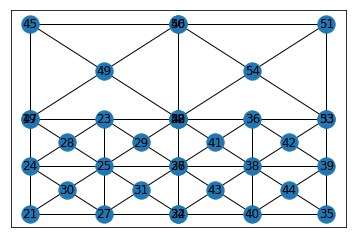

In [43]:
graph_layers = Graph_layers()
#graph_layers.display_i_layer(0)

base_node = list(graph_layers.get_layer(0)[0].nodes(data=True))[0]
#indexing from 0 
first_layer_G = graph_layers.get_layer(0)[0].copy()

#apply p1 production
G, i_node = p1(first_layer_G, base_node[0], graph_layers.get_node_id_gen()) 
graph_layers.add_new_layer(G)

#graph_layers.display_i_layer(1)

#apply p2 production
G = graph_layers.get_layer(1)[0]
nG = p2(G, 1, graph_layers.get_node_id_gen())
graph_layers.add_new_layer(nG)
graph_layers._layers[2][0].nodes(data=True)
#graph_layers.display_i_layer(2)

#apply p2 production 4 times
G = graph_layers.get_layer(2)[0]
graph_layers.add_new_layer( p2(G, 17, graph_layers.get_node_id_gen()))
graph_layers.add_to_last_layer(p2(G, 18, graph_layers.get_node_id_gen()))
#graph_layers.display_i_layer(3)

#apply p2 production
G = graph_layers.get_layer(2)
a,b = p10(G, 15, graph_layers.get_node_id_gen())
graph_layers.add_to_last_layer(a)
#graph_layers.display_i_layer(3)

#apply p2 production
G = graph_layers.get_layer(2)
a,b = p10(G, 16, graph_layers.get_node_id_gen())
graph_layers.add_to_last_layer(a)
graph_layers.display_i_layer(3)

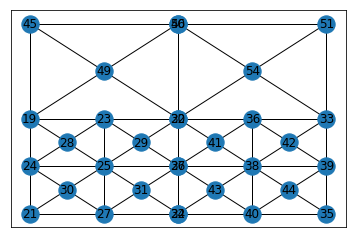

In [44]:
Gt = graph_layers.get_layer(2)
Gb = graph_layers.get_layer(3)
p11(Gt, Gb, [41,42,54], graph_layers.get_node_id_gen())

Gt = graph_layers.get_layer(2)
Gb = graph_layers.get_layer(3)
p11(Gt, Gb, [49,28,29], graph_layers.get_node_id_gen())
graph_layers.display_i_layer(3)

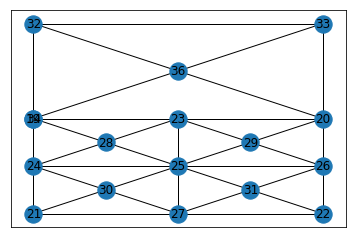

In [45]:
graph_layers = Graph_layers()
#graph_layers.display_i_layer(0)

base_node = list(graph_layers.get_layer(0)[0].nodes(data=True))[0]
#indexing from 0 
first_layer_G = graph_layers.get_layer(0)[0].copy()

#apply p1 production
G, i_node = p1(first_layer_G, base_node[0], graph_layers.get_node_id_gen()) 
graph_layers.add_new_layer(G)

#graph_layers.display_i_layer(1)

#apply p2 production
G = graph_layers.get_layer(1)[0]
nG = p2(G, 1, graph_layers.get_node_id_gen())
graph_layers.add_new_layer(nG)
graph_layers._layers[2][0].nodes(data=True)
#graph_layers.display_i_layer(2)

#apply p2 production 4 times
G = graph_layers.get_layer(2)[0]
graph_layers.add_new_layer( p2(G, 17, graph_layers.get_node_id_gen()))
#graph_layers.display_i_layer(3)


#apply p2 production
G = graph_layers.get_layer(2)
a,b = p10(G, 15, graph_layers.get_node_id_gen())
graph_layers.add_to_last_layer(a)
#graph_layers.display_i_layer(3)
G = graph_layers.get_layer(3)
H = compose(G[0], G[1])
G.remove(G[1])
G.remove(G[0])
graph_layers.add_to_last_layer(H)
reasing(H, 35 , 20)
H.remove_node(35)
graph_layers.display_i_layer(3)

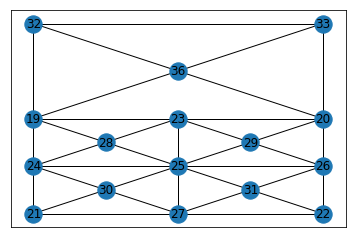

In [46]:
Gt = graph_layers.get_layer(2)
Gb = graph_layers.get_layer(3)
p12(Gt, Gb, [36,28,29], graph_layers.get_node_id_gen())
graph_layers.display_i_layer(3)

In [47]:
def p13(g1, g2, E_nodes1, E_nodes2): 
    assert(set(list(g1.nodes)).issuperset(set(E_nodes1)))
    assert(len(E_nodes1) == 2)
    assert(set(list(g2.nodes)).issuperset(set(E_nodes2)))
    assert(len(E_nodes2) == 2)
    assert(E_nodes1[1] == E_nodes2[1])
    
    assert(g1.nodes[E_nodes1[0]]['pos'] == g2.nodes[E_nodes2[0]]['pos'])
    assert(g1.nodes[E_nodes1[1]]['pos'] == g2.nodes[E_nodes2[1]]['pos'])
    
    #create return graph
    G2_cp = g2.copy()
    G2_cp.remove_node(E_nodes2[0])
    G = G2_cp
    for (node1, node2) in list(g2.edges(E_nodes2[0])):
        G.add_edges_from([(E_nodes1[0], node2)])
    return G 

In [48]:
def run_task_b():
    graph_layers = Graph_layers()
    
    base_node = list(graph_layers.get_layer(0)[0].nodes(data=True))[0]
    #indexing from 0 
    first_layer_G = graph_layers.get_layer(0)[0].copy()

    #apply p1 production
    G, i_node = p1(first_layer_G, base_node[0], graph_layers.get_node_id_gen()) 
    graph_layers.add_new_layer(G)

    
    #apply p2 production
    G = graph_layers.get_layer(1)[0]
    nG = p2(G, 1, graph_layers.get_node_id_gen())
    graph_layers.add_new_layer(nG)
    graph_layers._layers[2][0].nodes(data=True)
    
    #apply p2 production 3 times
    G = graph_layers.get_layer(2)[0]
    graph_layers.add_new_layer( p2(G, 16, graph_layers.get_node_id_gen()))
    graph_layers.add_to_last_layer(p2(G, 17, graph_layers.get_node_id_gen()))
    graph_layers.add_to_last_layer(p2(G, 18, graph_layers.get_node_id_gen()))
    
    
    #apply P7 twice
    apply_P7(graph_layers.get_layer(2), graph_layers.get_layer(3), [30, 31, 54, 55], graph_layers.get_node_id_gen())
    apply_P7(graph_layers.get_layer(2), graph_layers.get_layer(3), [42, 44, 54, 56], graph_layers.get_node_id_gen())
    #apply p11 once
    single_g, _ = p10(graph_layers.get_layer(2), 15, graph_layers.get_node_id_gen())
    graph_layers.add_to_last_layer(single_g)
    
    #apply p11
    child_graph1 =  graph_layers.get_layer(3)[0]
    child_graph2 =  graph_layers.get_layer(3)[1]
    nG = p11_v2(graph_layers.get_layer(2), child_graph1, child_graph2, [32, 36, 33], [60, 61])
    graph_layers.get_layer(3).remove(child_graph1)
    graph_layers.get_layer(3).remove(child_graph2)
    graph_layers.add_to_last_layer(nG)
    
    #apply p12
    nG = p12(graph_layers.get_layer(2), graph_layers.get_layer(3), [62, 28, 30], graph_layers.get_node_id_gen())
    graph_layers.get_layer(3).remove(graph_layers.get_layer(3)[0])
    graph_layers.add_to_last_layer(nG)
    
    #show layers
    print('LAYER 0')
    graph_layers.display_i_layer(0)
    print('LAYER 1')
    graph_layers.display_i_layer(1)
    print('LAYER 2')
    graph_layers.display_i_layer(2)
    print('LAYER 3')
    graph_layers.display_i_layer(3)

LAYER 0


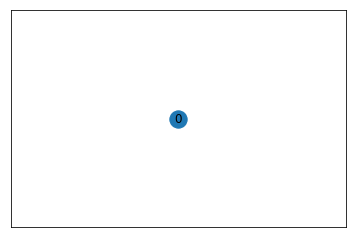

LAYER 1


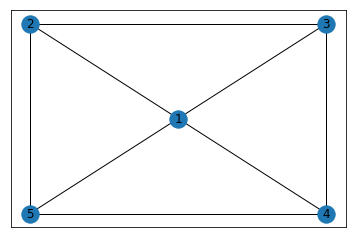

LAYER 2


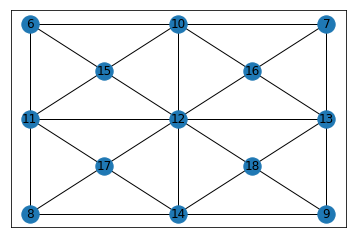

LAYER 3


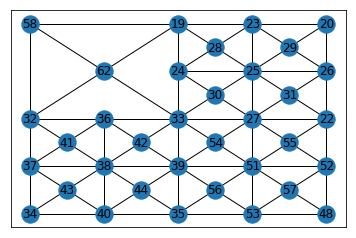

In [49]:
run_task_b()

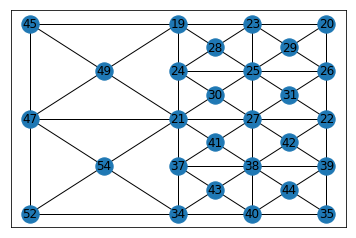

In [50]:
#c
graph_l = Graph_layers()
base_node = list(graph_l.get_layer(0)[0].nodes(data=True))[0]
first_layer = graph_l.get_layer(0)[0].copy()

#apply p1 production
G, i_node = p1(first_layer, base_node[0], graph_l.get_node_id_gen()) 
graph_l.add_new_layer(G)

#apply p2 production
graph_layer2 = p2(G, 1, graph_l.get_node_id_gen())
graph_l.add_new_layer(graph_layer2)

#apply p2 production to right upper corner
graph_layer3_1 = p2(graph_layer2, 16, graph_l.get_node_id_gen())
graph_l.add_new_layer(graph_layer3_1)
#print(graph_layer3_1.nodes.data())

#apply p2 production to right bottom corner
graph_layer3_2 = p2(graph_layer2, 18, graph_l.get_node_id_gen())
graph_l.add_to_last_layer(graph_layer3_2)
#(graph_layer3_2.nodes.data())

#apply p10 production to left upper corner
graph_layer3_3 = p10([graph_layer2], 15, graph_l.get_node_id_gen())
graph_l.add_to_last_layer(graph_layer3_3[0])

#apply p10 production to left bottom corner
graph_layer3_3 = p10([graph_layer2], 17, graph_l.get_node_id_gen())
graph_l.add_to_last_layer(graph_layer3_3[0])

#apply p7 to right upper corner and right bottom corner 
apply_P7(graph_l.get_layer(2), graph_l.get_layer(3), [30, 31, 41, 42], graph_l.get_node_id_gen())

#apply p11 to left upper corner and right upper corner
child_graph1 = graph_l.get_layer(3)[2]
child_graph2 =  graph_l.get_layer(3)[0]
nG = p11_v2(graph_l.get_layer(2), child_graph1, child_graph2, [19,24,21], [46,48])
graph_l.get_layer(3).remove(child_graph1)
graph_l.get_layer(3).remove(child_graph2)
graph_l.add_to_last_layer(nG)

#apply p11 to left bottom corner and right bottom corner
child_graph1 = graph_l.get_layer(3)[1]
child_graph2 =  graph_l.get_layer(3)[0]
nG2 = p11_v2(graph_l.get_layer(2), child_graph1, child_graph2, [21,37,34], [51,53])
graph_l.get_layer(3).remove(child_graph1)
graph_l.get_layer(3).remove(child_graph2)
graph_l.add_to_last_layer(nG2)
#graph_l.display_i_layer(3)

layer3_G = graph_l.get_layer(3)[0]
G = p13(layer3_G, layer3_G, [47,21], [50,21])
graph_l.get_layer(3).remove(graph_l.get_layer(3)[0])
graph_l.add_to_last_layer(G)
graph_l.display_i_layer(3)